### start

In [1]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.evaluation_orchestrator as eo
import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.custom_transforms as ct
import script_modeling.entry_helpers as h
import script_modeling.single_model_entry as sme
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import wallet_insights.wallet_validation_analysis as wiva
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    eo, sime,
    wm, sm, wo,
    ct, h, sme,
    wime, wiva,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/jeremymeadow/Library/Application Support/sagemaker/config.yaml


[14/Aug/25 18:48:15] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[14/Aug/25 18:48:15] MILESTONE [2672207814.<module>:140] Good morning, let's get to work


# Model Training

## Data Prep

#### load all local data

In [78]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[14/Aug/25 14:32:42] INFO [workflow_orchestrator.load_all_training_data:101] Auto-detected date_suffixes from config: ['230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '240106', '240306', '240505', '231207', '240205', '240405', '240604', '240704']
[14/Aug/25 14:32:42] MILESTONE [workflow_orchestrator.load_all_training_data:118] <DEV> Loading training data for 19 periods: ['230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '240106', '240306', '240505', '231207', '240205', '240405', '240604', '240704']
[14/Aug/25 14:32:43] INFO [workflow_orchestrator.load_all_training_data:134] Training data loaded successfully: 152,000 total rows and 1 offsets for each date_suffix.


#### preprocess and concatenate

In [80]:
results = workflow_orch.preprocess_all_training_data()

[14/Aug/25 14:32:51] INFO [workflow_orchestrator.preprocess_all_training_data:156] Preprocessing 19 date periods...
[14/Aug/25 14:32:51] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[14/Aug/25 14:32:51] INFO [wallet_preprocessor._handle_missing_values:237] Filled NaN values in 103 columns for x_train.
[14/Aug/25 14:32:51] INFO [wallet_preprocessor._save_preprocessed_df:412] Saved preprocessed train to ../s3_uploads/wallet_training_data_preprocessed/dda_956_importance_dev/230111/train.parquet
[14/Aug/25 14:32:51] INFO [wallet_preprocessor._save_preprocessed_df:412] Saved preprocessed train_y to ../s3_uploads/wallet_training_data_preprocessed/dda_956_importance_dev/230111/train_y.parquet
[14/Aug/25 14:32:51] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 1,000 rows × 231 cols.
[14/Aug/25 14:32:51] INFO [wallet_preprocessor._handle_missing_values:237] Filled NaN values in 103 columns for x

In [81]:
workflow_orch.concatenate_all_preprocessed_data()

[14/Aug/25 14:32:54] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:194] Loading preprocessed training data...
[14/Aug/25 14:32:54] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:197] Beginning concatenation of preprocessed data from Parquet...
[14/Aug/25 14:32:54] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated train_index.parquet with 14000 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_dev/train_index.parquet
[14/Aug/25 14:32:58] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:267] Saved concatenated train.csv.gz with 14000 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_dev/train.csv.gz
[14/Aug/25 14:32:58] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:260] Saved concatenated eval_index.parquet with 6000 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_dev/eval_index.parquet
[14/Aug/25 14:32:59] INFO [work

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
local_dir = f"{local_dir}_dev" if sage_wallets_config['training_data']['dataset'] == 'dev' else local_dir
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [82]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[14/Aug/25 14:33:03] INFO [workflow_orchestrator.upload_concatenated_training_data:380] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[14/Aug/25 14:33:03] INFO [workflow_orchestrator.upload_concatenated_training_data:383] Uploading concatenated splits in parallel with 4 threads...
[14/Aug/25 14:33:03] INFO [workflow_orchestrator._upload_split:404] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importance-dev/eval.csv.gz', proceeding with upload...
[14/Aug/25 14:33:03] INFO [workflow_orchestrator._upload_split:404] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importance-dev/val.csv.gz', proceeding with upload...
[14/Aug/25 14:33:03] INFO [workflow_orchestrator._upload_split:404] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importance-dev/train.csv.gz', proceeding with upload...
[14/Aug/25 14:3

## Epoch Shifts Sequence

#### train all epoch shifts

In [3]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[14/Aug/25 18:04:44] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials


[14/Aug/25 18:04:44] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[14/Aug/25 18:04:44] INFO [workflow_orchestrator.upload_concatenated_training_data:382] Uploading concatenated splits in parallel with 4 threads...
[14/Aug/25 18:04:44] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-956-importance/val.csv.gz
[14/Aug/25 18:04:44] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-956-importance/train.csv.gz
[14/Aug/25 18:04:44] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-956-importance/test.csv.gz
[14/Aug/25 18:04:44] INFO [workflow_orchestrator._upload_split:396] File ex

2025-08-15 01:04:47 Starting - Starting the training job2025-08-15 01:04:47 Starting - Starting the training job2025-08-15 01:04:47 Starting - Starting the training job...2025-08-15 01:04:48 Starting - Starting the training job.2025-08-15 01:04:49 Starting - Starting the training job.2025-08-15 01:04:52 Starting - Starting the training job.............

2025-08-15 01:05:01 Starting - Preparing the instances for training2025-08-15 01:05:12 Starting - Preparing the instances for training
2025-08-15 01:05:20 Downloading - Downloading input data...
2025-08-15 01:05:22 Downloading - Downloading input data.
2025-08-15 01:05:20 Downloading - Downloading input data.
2025-08-15 01:05:26 Downloading - Downloading input data.............
2025-08-15 01:05:36 Downloading - Downloading input data
2025-08-15 01:05:22 Downloading - Downloading input data..................
2025-08-15 01:06:21 Downloading - Downloading the training image
2025-08-15 01:06:21 Downloading - Downloading the training image
2

[14/Aug/25 18:09:41] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0814-180445/output/model.tar.gz
[14/Aug/25 18:09:41] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=240


[62]#011eval-aucpr:0.11986
[63]#011eval-aucpr:0.11847
[64]#011eval-aucpr:0.11782
[65]#011eval-aucpr:0.10522
[66]#011eval-aucpr:0.10509
[67]#011eval-aucpr:0.10604
[68]#011eval-aucpr:0.10531
[29]#011eval-aucpr:0.18479
[30]#011eval-aucpr:0.18479
[31]#011eval-aucpr:0.18449
[32]#011eval-aucpr:0.18355
[33]#011eval-aucpr:0.18327
[34]#011eval-aucpr:0.18366
[35]#011eval-aucpr:0.18372
[36]#011eval-aucpr:0.18430
[37]#011eval-aucpr:0.18476
[38]#011eval-aucpr:0.18461
[39]#011eval-aucpr:0.18641
[40]#011eval-aucpr:0.18673
[41]#011eval-aucpr:0.18765
[42]#011eval-aucpr:0.18741
[43]#011eval-aucpr:0.18692
[44]#011eval-aucpr:0.18668
[45]#011eval-aucpr:0.18688
[46]#011eval-aucpr:0.18742
[47]#011eval-aucpr:0.18916
[48]#011eval-aucpr:0.18826
[49]#011eval-aucpr:0.18778
[50]#011eval-aucpr:0.18630
[51]#011eval-aucpr:0.18764
[52]#011eval-aucpr:0.18740
[53]#011eval-aucpr:0.18722
[54]#011eval-aucpr:0.18647
[55]#011eval-aucpr:0.18643
[56]#011eval-aucpr:0.18672
[57]#011eval-aucpr:0.18427
[58]#011eval-aucpr:0.18296
[

[14/Aug/25 18:10:11] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:11] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=300


Training seconds: 264
Billable seconds: 264


[14/Aug/25 18:10:16] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:16] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=120



2025-08-15 01:10:01 Completed - Training job completed

2025-08-15 01:10:17 Uploading - Uploading generated training model
2025-08-15 01:10:17 Completed - Training job completed

2025-08-15 01:10:22 Uploading - Uploading generated training model
2025-08-15 01:10:22 Completed - Training job completed
Training seconds: 265
Billable seconds: 265


[14/Aug/25 18:10:41] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:41] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=180


Training seconds: 295
Billable seconds: 295


[14/Aug/25 18:10:41] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:41] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=60


Training seconds: 300
Billable seconds: 300


[14/Aug/25 18:10:42] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:42] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=0
[14/Aug/25 18:10:42] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:515] Epoch shift training complete: 6/6 models successful


#### predict all epoch_shifts

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)

[14/Aug/25 18:10:43] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:692] Starting predictions for 6 epoch shifts using 15 threads...
[14/Aug/25 18:10:43] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0814-180445): s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:43] INFO [wallet_modeler.predict_with_local_transform:389] Starting local transform for test dataset...
[14/Aug/25 18:10:43] INFO [wallet_modeler.predict_with_local_transform:389] Starting local transform for val dataset...
[14/Aug/25 18:10:43] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0814-180445): s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0814-180445/output/model.tar.gz
[14/Aug/25 18:10:43] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0814-18

.....................

[14/Aug/25 18:17:42] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names
[14/Aug/25 18:17:43] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data


..

[14/Aug/25 18:17:46] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names
[14/Aug/25 18:17:47] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names


.

[14/Aug/25 18:17:47] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names


...

[14/Aug/25 18:17:47] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data
[14/Aug/25 18:17:47] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names
[14/Aug/25 18:17:48] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data
[14/Aug/25 18:17:48] INFO [wallet_modeler._load_local_concatenated_data:711] Loaded val data: 2,180,821 rows × 231 columns with feature names
[14/Aug/25 18:17:48] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data
[14/Aug/25 18:17:48] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data


......

[14/Aug/25 18:17:54] INFO [wallet_modeler._apply_feature_selection_locally:744] No drop patterns configured, returning unfiltered data


........................................................................................................................................................................................................................................................................................................................................!

[14/Aug/25 18:22:31] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh60/wallet-scoring-sh60-181721-concat-test/test-filtered-20250814-181108.csv.gz.out



.

[14/Aug/25 18:22:32] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh60/test.csv.out.
[14/Aug/25 18:22:32] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:22:32] INFO [wallet_modeler.None:359] (11m49s) Completed predict_with_local_transform.


...............!

[14/Aug/25 18:22:50] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh300/wallet-scoring-sh300-181724-concat-test/test-filtered-20250814-181108.csv.gz.out



.

[14/Aug/25 18:22:51] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh300/test.csv.out.
[14/Aug/25 18:22:51] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:22:51] INFO [wallet_modeler.None:359] (12m7s) Completed predict_with_local_transform.


...!

[14/Aug/25 18:22:55] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh0/wallet-scoring-sh0-181724-concat-test/test-filtered-20250814-181108.csv.gz.out


[14/Aug/25 18:22:56] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh0/test.csv.out.
[14/Aug/25 18:22:56] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:22:56] INFO [wallet_modeler.None:359] (12m13s) Completed predict_with_local_transform.


.....!

[14/Aug/25 18:23:02] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh240/wallet-scoring-sh240-181721-concat-test/test-filtered-20250814-181108.csv.gz.out


[14/Aug/25 18:23:03] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh240/test.csv.out.
[14/Aug/25 18:23:03] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:23:03] INFO [wallet_modeler.None:359] (12m19s) Completed predict_with_local_transform.


.!

[14/Aug/25 18:23:07] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh180/wallet-scoring-sh180-181721-concat-test/test-filtered-20250814-181108.csv.gz.out


[14/Aug/25 18:23:08] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh180/test.csv.out.
[14/Aug/25 18:23:08] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:23:08] INFO [wallet_modeler.None:359] (12m24s) Completed predict_with_local_transform.


!

[14/Aug/25 18:23:12] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importance/sh120/wallet-scoring-sh120-181726-concat-test/test-filtered-20250814-181108.csv.gz.out


[14/Aug/25 18:23:13] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_5m_nodrops/sh120/test.csv.out.
[14/Aug/25 18:23:13] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[14/Aug/25 18:23:13] INFO [wallet_modeler.None:359] (12m29s) Completed predict_with_local_transform.


#### evaluate importances

In [3]:
# Import and reload modules (your existing pattern)
[importlib.reload(module) for module in modules]

# Load configs (your existing pattern)
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Create evaluation orchestrator
import sage_wallet_insights.evaluation_orchestrator as eo
eval_orch = eo.EvaluationOrchestrator(sage_wallets_config, sage_wallets_modeling_config)
complete_importance_data = eval_orch.generate_all_feature_importances()

[14/Aug/25 18:39:03] MILESTONE [evaluation_orchestrator.generate_all_feature_importances:84] Generating feature importances for 6 epoch shifts...
[14/Aug/25 18:39:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:39:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:39:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:39:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:39:03] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0814-180445): s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0814-180445/output/model.tar.gz
[14/Aug/25 18:39:03] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0814-180445): s3://wallet-scrip

In [4]:
# w regularization
feature_categories_filter = [
    # 'cw_coin_trends',
    # 'macro',
    # 'scenario'
    # 'timing',
    # 'trading'
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.filter_and_aggregate_importances(
    feature_categories_filter=feature_categories_filter,
    # feature_names_filter=feature_names_filter,
    groups=groups,
    complete_df=complete_importance_data
)

# View results
u.display_full(all_importance_stats.sort_values(by='pct_max',ascending=False))

[14/Aug/25 18:42:23] INFO [evaluation_orchestrator.filter_and_aggregate_importances:229] Filtered importance analysis: 18 feature groups across 6 models


column_count  pct_mean  pct_median  pct_min  pct_max  \
feature_category                                                         
macro                       32    0.5632      0.5482   0.4642   0.6729   
cw_coin_trends              32    0.2212      0.2227    0.159   0.2792   
cw_scenario                 32    0.0387       0.041   0.0161   0.0581   
cw_mktcap                    6    0.0353       0.036   0.0271   0.0446   
timing                      33    0.0214      0.0177   0.0032   0.0427   
cw_transfers                16    0.0175      0.0162   0.0055   0.0351   
transfers                   20    0.0248      0.0273   0.0104   0.0332   
cw_trading                   3    0.0178       0.017   0.0102   0.0281   
scenario                    16    0.0139      0.0139   0.0049   0.0213   
trading                      6    0.0134      0.0139   0.0101   0.0161   
cw_performance               4    0.0102      0.0105   0.0043   0.0156   
performance                  4    0.0068      0.0058    0.005   0.0119   
cw_timing                   10    0.0059      0.0052        0   0.0117   
cw_cluster                   5    0.0023       0.002        0   0.0059   
cluster                      5    0.0016           0        0    0.005   
mktcap                       4    0.0026      0.0023        0   0.0049   
balance                      1     0.002      0.0021   0.0004   0.0029   
cw_balance                   1    0.0014      0.0014        0   0.0026   

                  pct_std  total_importance_sum  importance_mean  
feature_category                                                  
macro              0.0874              90339.57          15056.6  
cw_coin_trends       0.04              33115.09          5519.18  
cw_scenario        0.0189               4844.59           807.43  
cw_mktcap          0.0061               5320.59           886.76  
timing             0.0165               2299.42           383.24  
cw_transfers       0.0117               1991.26           331.88  
transfers          0.0091               3254.77           542.46  
cw_trading         0.0061               2546.23           424.37  
scenario           0.0064                1713.7           285.62  
trading            0.0023               1924.23            320.7  
cw_performance     0.0039               1397.75           232.96  
performance        0.0026                988.04           164.67  
cw_timing          0.0044                 691.2            115.2  
cw_cluster          0.002                290.28            48.38  
cluster            0.0025                124.55            20.76  
mktcap              0.002                283.55            47.26  
balance            0.0009                275.45            45.91  
cw_balance         0.0009                180.43            30.07

#### evaluate all epoch shifts

In [2]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


eval_orch = eo.EvaluationOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = eval_orch.build_all_epoch_shift_evaluators()


[14/Aug/25 18:48:21] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:249] Building evaluators for 6 epoch shifts using 6 threads...
[14/Aug/25 18:48:21] INFO [evaluation_orchestrator.build_all_epoch_shift_evaluators:254] Loading shared target and feature data...
[14/Aug/25 18:49:10] INFO [evaluation_orchestrator.build_all_epoch_shift_evaluators:258] Target and feature data loaded successfully.
[14/Aug/25 18:49:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:49:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:49:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:49:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/25 18:49:10] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[14/Aug/

Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 0 shift: [1410, 1440, 1470, 1500, 1530, 1560]
Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 120 shift: [1530, 1560, 1590, 1620, 1650, 1680]
Unique offset_date values in data: [840.0, 870.0, 900.0, 930.0, 960.0, 990.0, 1020.0, 1050.0, 1080.0, 1110.0, 1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0

[14/Aug/25 18:50:40] INFO [model_evaluation.None:387] (1m6s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 232,762 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 12,657,555
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 34,310 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 927,281,984
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 78,010 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 346
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 71,415 rows
Row filtering complete: 138,236 rows removed (59.4%), 94,526 rows remaining
Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 300 shift: [1890, 1920]
Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 13

[14/Aug/25 18:50:41] INFO [model_evaluation.None:387] (1m7s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 251,656 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,711,453
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 40,937 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 996,896,256
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 76,009 rows
Column stats for trading|unique_coins_traded|all_windows:
Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 180 shift: [1770, 1800]


[14/Aug/25 18:50:42] INFO [model_evaluation.None:387] (1m10s) Completed _apply_custom_transforms_to_concatenated_data.


Unique offset_date values in data: [1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 60 shift: [1650, 1680]
  Min: 3
  Max: 347
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 80,481 rows
Row filtering complete: 147,787 rows removed (58.7%), 103,869 rows remaining
Starting with 171,623 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,063,788
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 33,197 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,253
  Max: 929,659,456
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 47,694 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 349
Filter 'trading|unique_coins_traded|all_window

[14/Aug/25 18:50:42] INFO [model_evaluation.None:387] (1m8s) Completed _apply_custom_transforms_to_concatenated_data.
[14/Aug/25 18:50:42] INFO [model_evaluation.None:387] (1m8s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 176,272 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 10,752,532
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 36,119 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 956,730,112
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 56,172 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 343
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 55,176 rows
Row filtering complete: 107,156 rows removed (60.8%), 69,116 rows remaining
Starting with 283,340 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,403,229
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 33,588 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,022
  Max: 980,591,168
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_

[14/Aug/25 18:50:42] INFO [model_evaluation.None:387] (1m9s) Completed _apply_custom_transforms_to_concatenated_data.
[14/Aug/25 18:50:50] INFO [model_evaluation.None:36] (1m16s) Completed create_concatenated_sagemaker_evaluator.
[14/Aug/25 18:50:50] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=300
[14/Aug/25 18:50:50] INFO [model_evaluation.None:36] (1m16s) Completed create_concatenated_sagemaker_evaluator.
[14/Aug/25 18:50:50] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=240
[14/Aug/25 18:50:50] INFO [model_evaluation.None:36] (1m16s) Completed create_concatenated_sagemaker_evaluator.
[14/Aug/25 18:50:50] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=60
[14/Aug/25 18:50:50] INFO [model_evaluation.None:36] (1m17s) Completed create_concatenated_sagemaker_evaluator.
[14/Aug/25 18:50:50] MILESTONE [evaluat

[14/Aug/25 18:50:52] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:52] WARNING [3644866435.<module>:6]                 0: 2024-06-04
[14/Aug/25 18:50:52] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:52] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0814-180445/output/model.tar.gz
Test Samples:             37,062
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.526  |  0.696
Val Accuracy:               0.794  |  0.811
Val Precision:              0.058  |  0.373
Val Recall:                 0.226  |  0.377
Val F1 Score:               0.093  |  0.375

Validation Retur

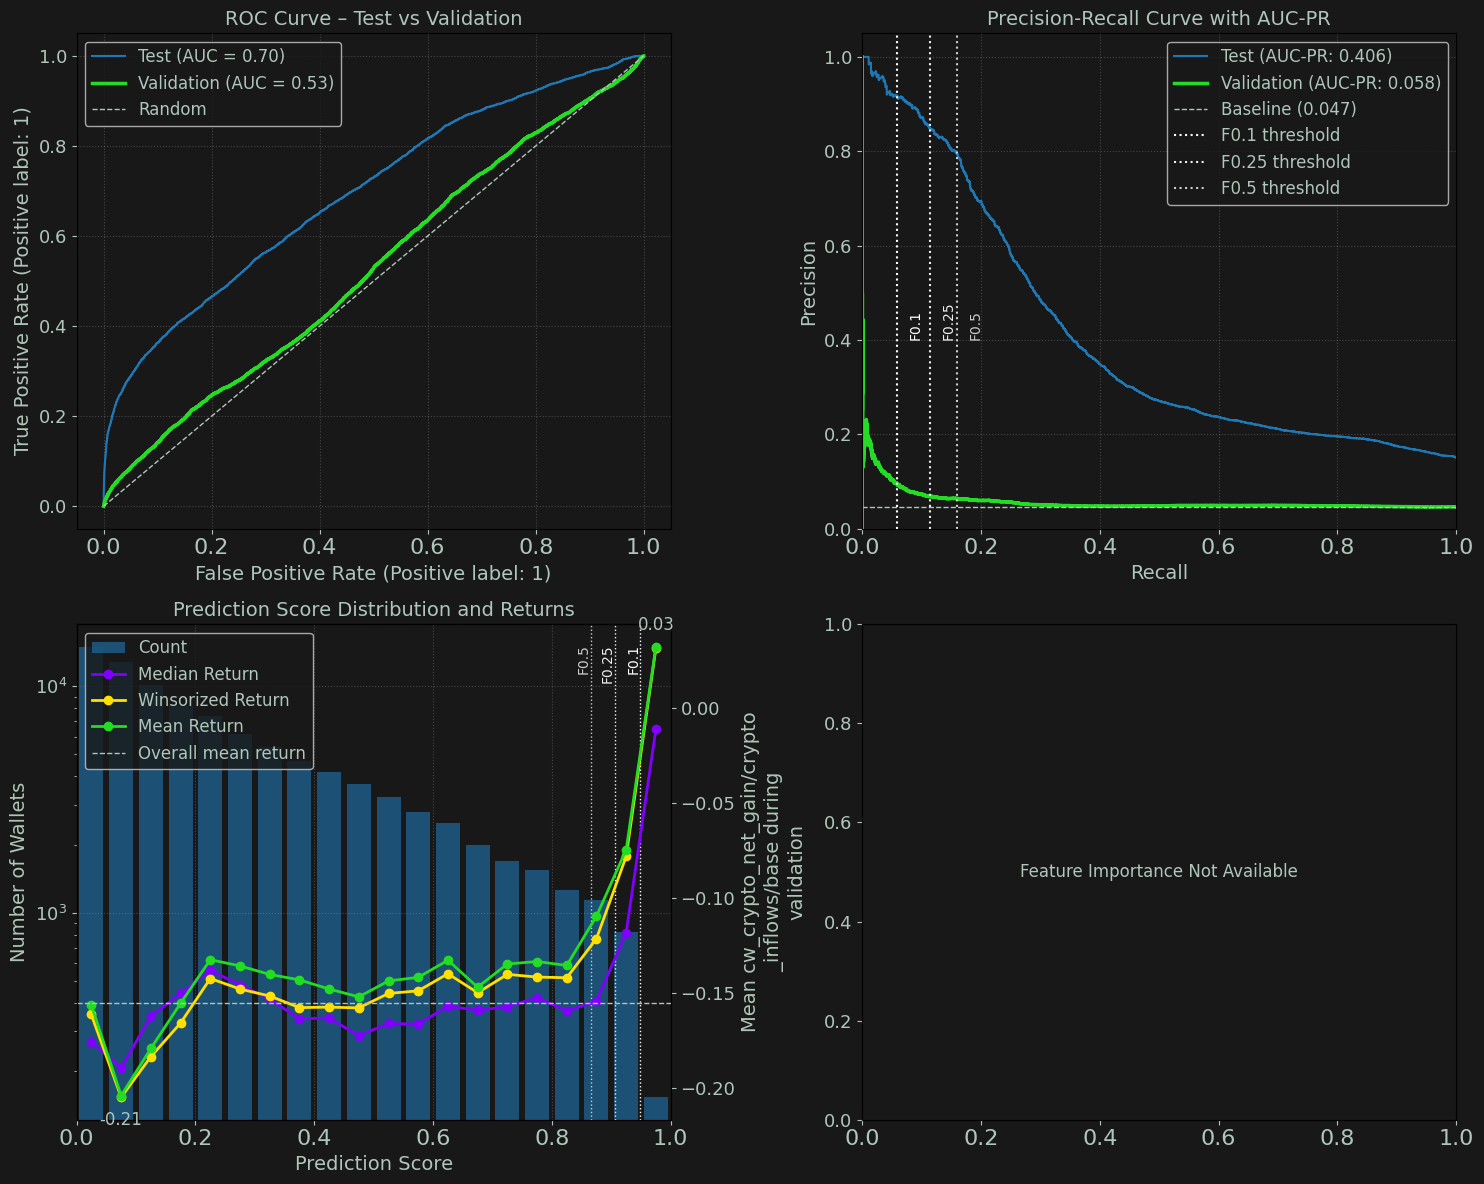

[14/Aug/25 18:50:53] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:53] WARNING [3644866435.<module>:6]                 60: 2024-08-03
[14/Aug/25 18:50:53] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:53] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0814-180445/output/model.tar.gz
Test Samples:             42,436
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.563  |  0.647
Val Accuracy:               0.758  |  0.795
Val Precision:              0.256  |  0.279
Val Recall:                 0.220  |  0.371
Val F1 Score:               0.237  |  0.318

Validation 

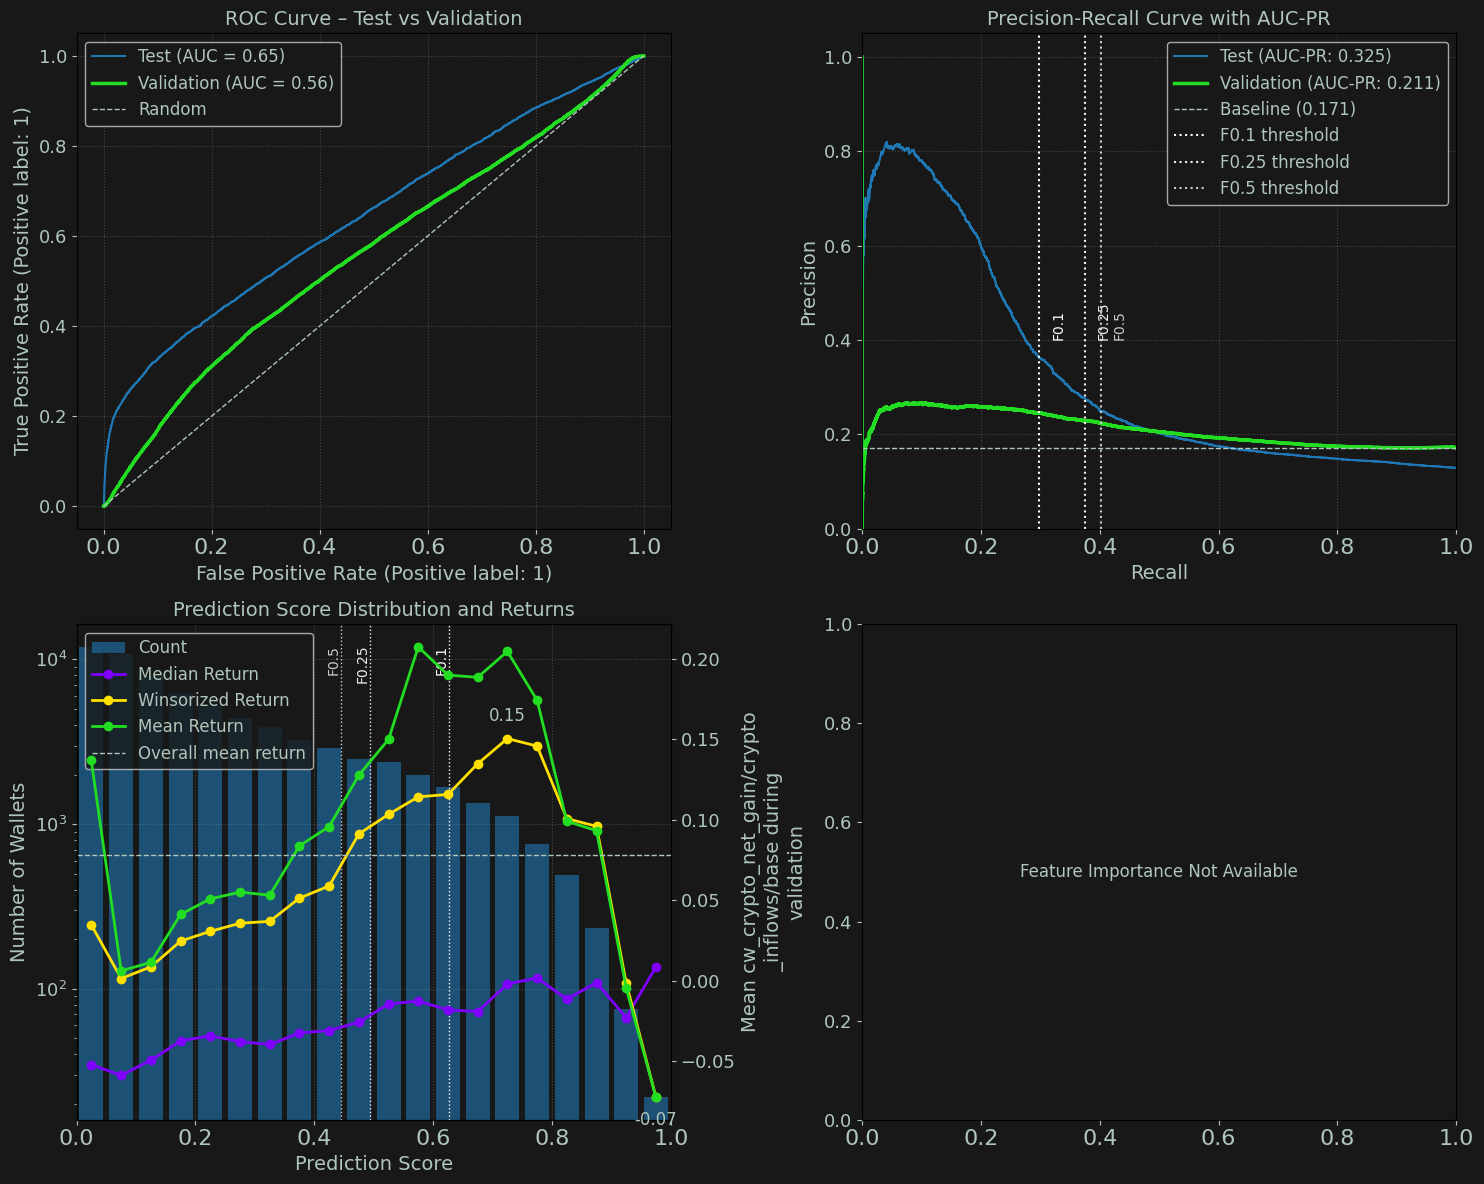

[14/Aug/25 18:50:53] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:53] WARNING [3644866435.<module>:6]                 120: 2024-10-02
[14/Aug/25 18:50:53] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:53] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0814-180445/output/model.tar.gz
Test Samples:             39,432
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.492  |  0.582
Val Accuracy:               0.544  |  0.605
Val Precision:              0.282  |  0.099
Val Recall:                 0.359  |  0.507
Val F1 Score:               0.316  |  0.166

Validati

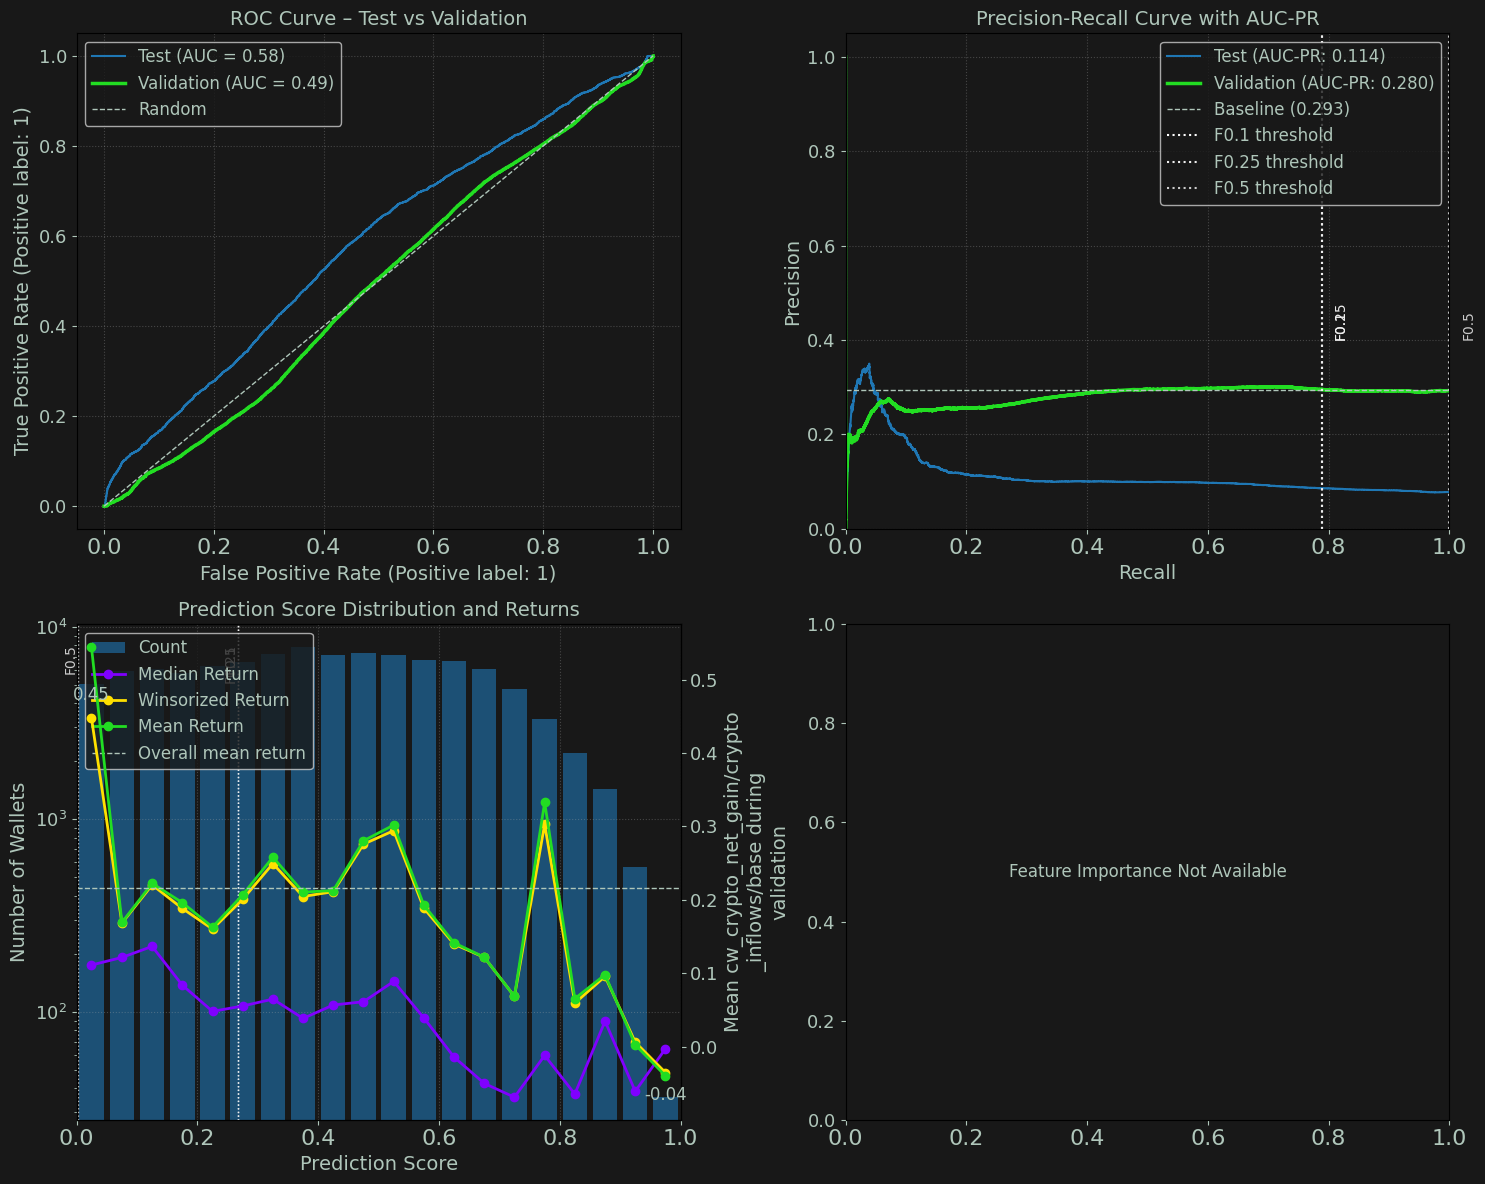

[14/Aug/25 18:50:53] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:53] WARNING [3644866435.<module>:6]                 180: 2024-12-01
[14/Aug/25 18:50:53] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:53] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0814-180445/output/model.tar.gz
Test Samples:             40,270
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.538  |  0.518
Val Accuracy:               0.918  |  0.823
Val Precision:              0.084  |  0.221
Val Recall:                 0.002  |  0.004
Val F1 Score:               0.003  |  0.008

Validatio

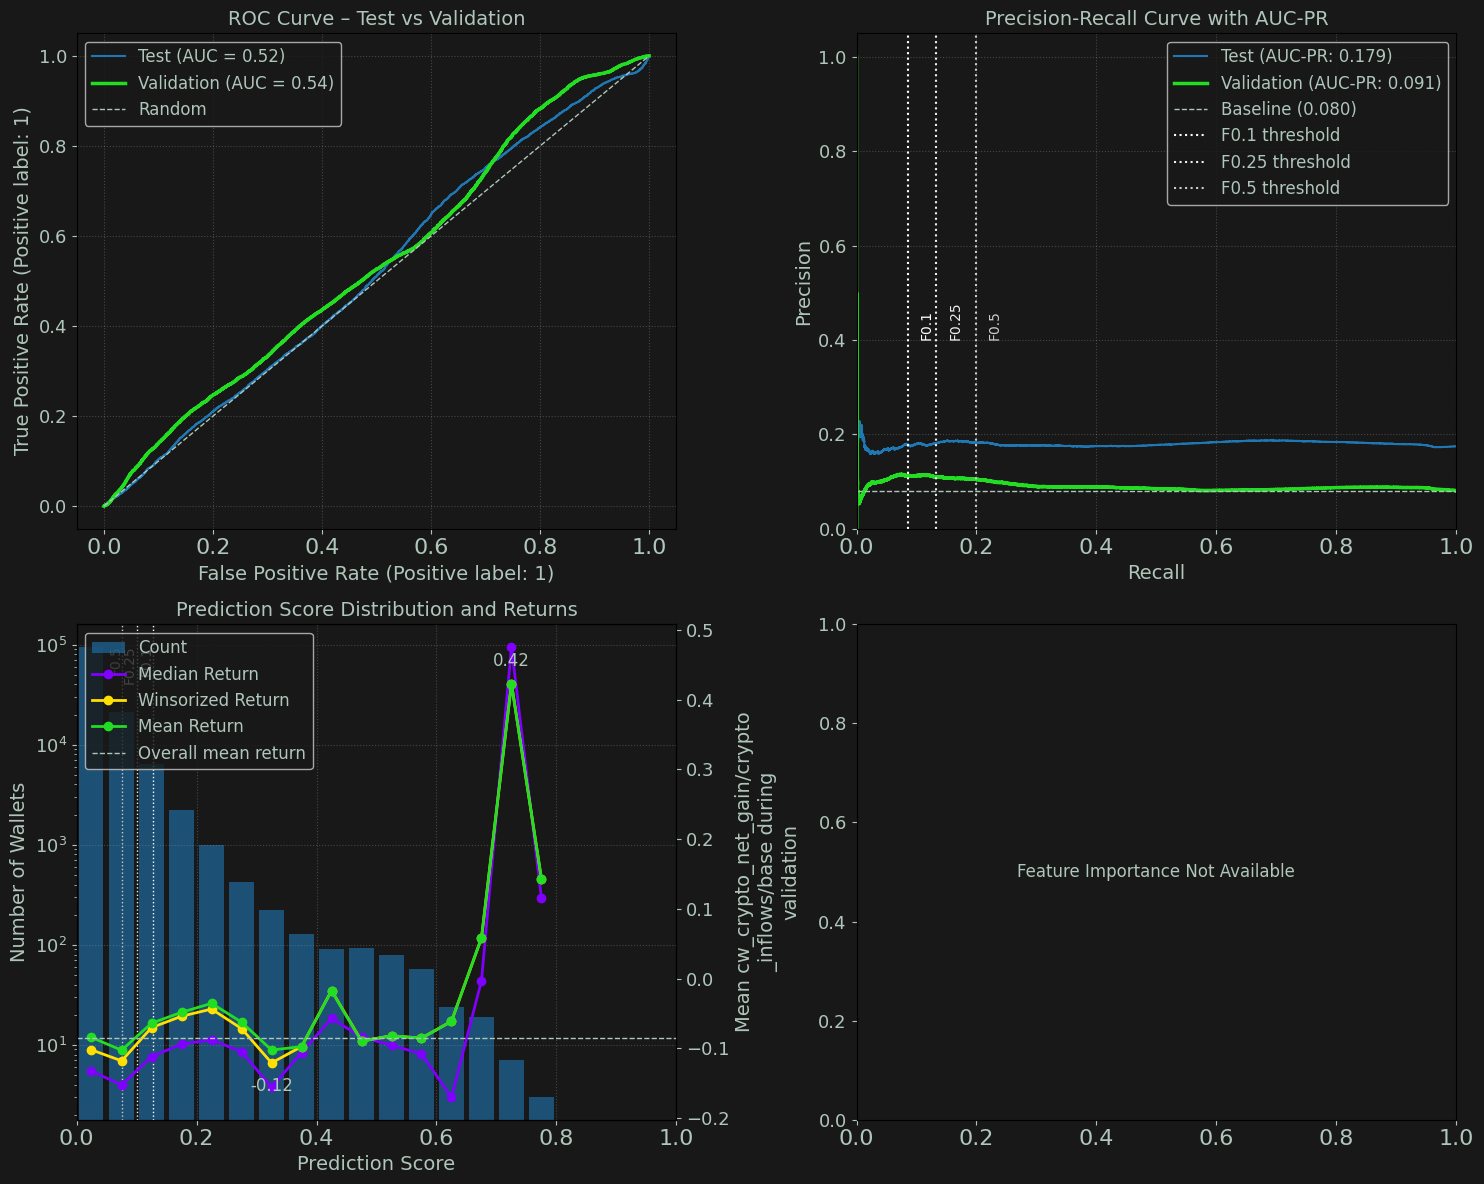

[14/Aug/25 18:50:54] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:54] WARNING [3644866435.<module>:6]                 240: 2025-01-30
[14/Aug/25 18:50:54] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:54] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0814-180445/output/model.tar.gz
Test Samples:             45,080
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.709  |  0.512
Val Accuracy:               0.974  |  0.817
Val Precision:              0.030  |  0.199
Val Recall:                 0.013  |  0.014
Val F1 Score:               0.018  |  0.026

Validation

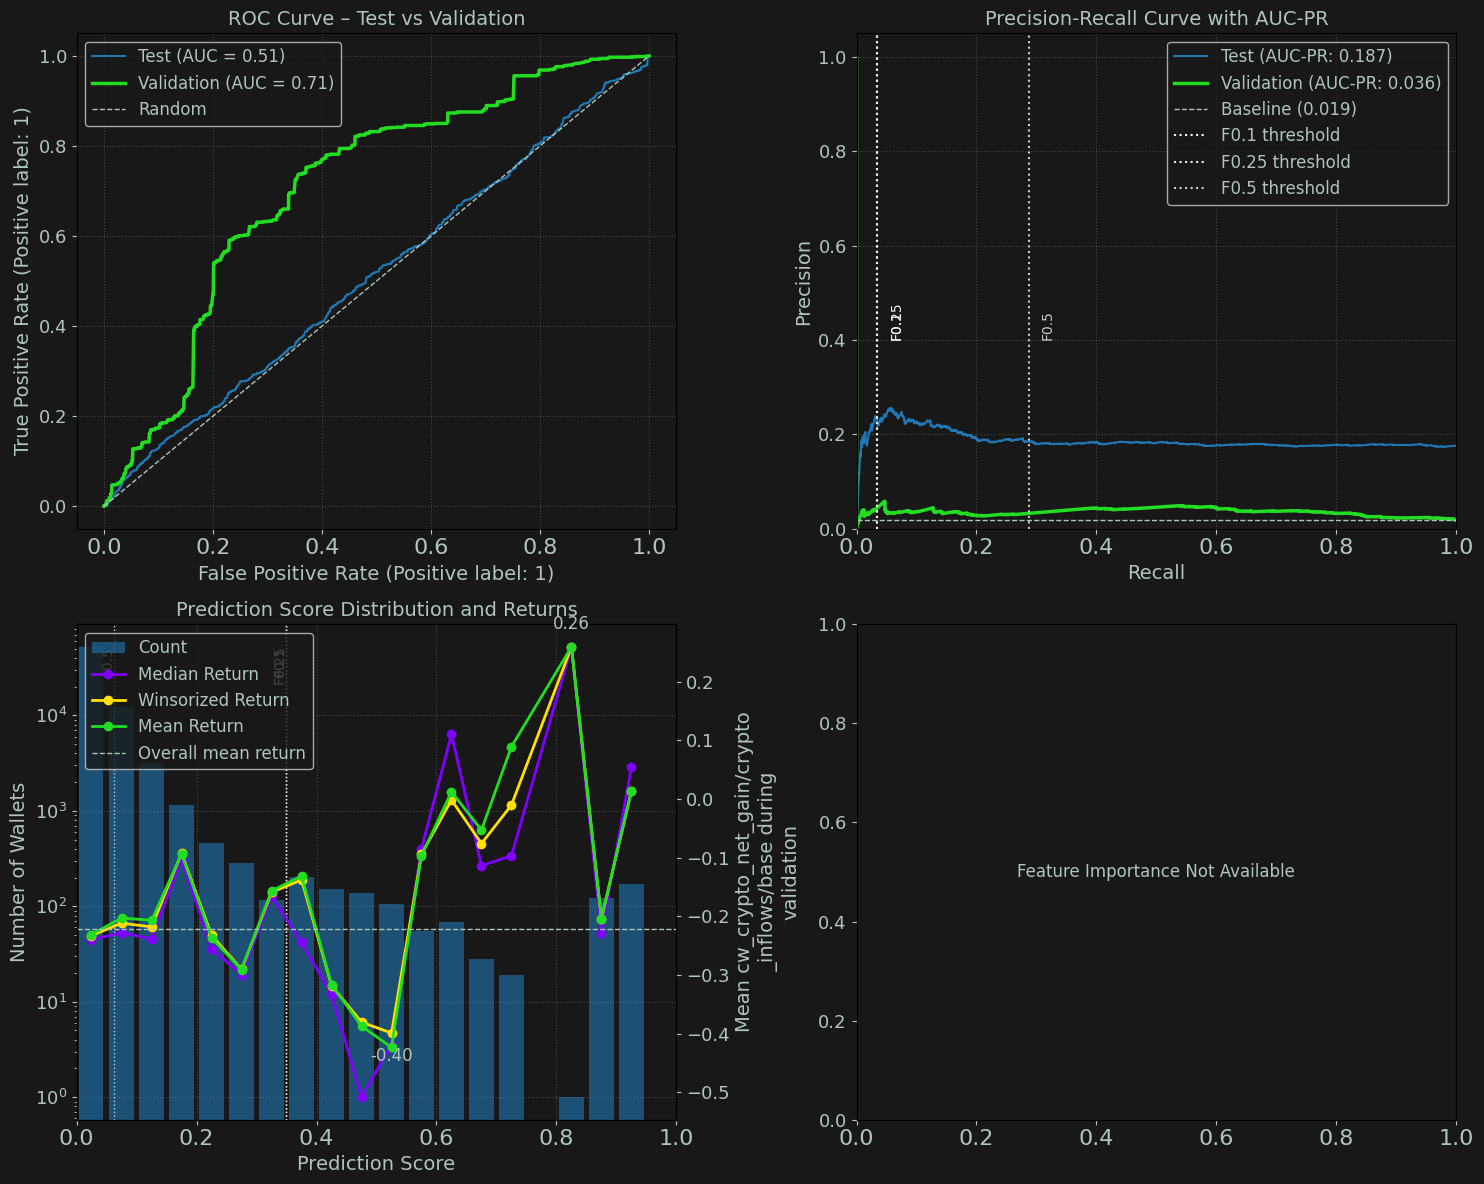

[14/Aug/25 18:50:54] INFO [3644866435.<module>:5] -------------------------------------------------
[14/Aug/25 18:50:54] WARNING [3644866435.<module>:6]                 300: 2025-03-31
[14/Aug/25 18:50:54] INFO [3644866435.<module>:7] -------------------------------------------------
[14/Aug/25 18:50:54] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0814-180445/output/model.tar.gz
Test Samples:             45,393
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.507  |  0.499
Val Accuracy:               0.810  |  0.838
Val Precision:              0.080  |  0.192
Val Recall:                 0.002  |  0.048
Val F1 Score:               0.005  |  0.077

Validatio

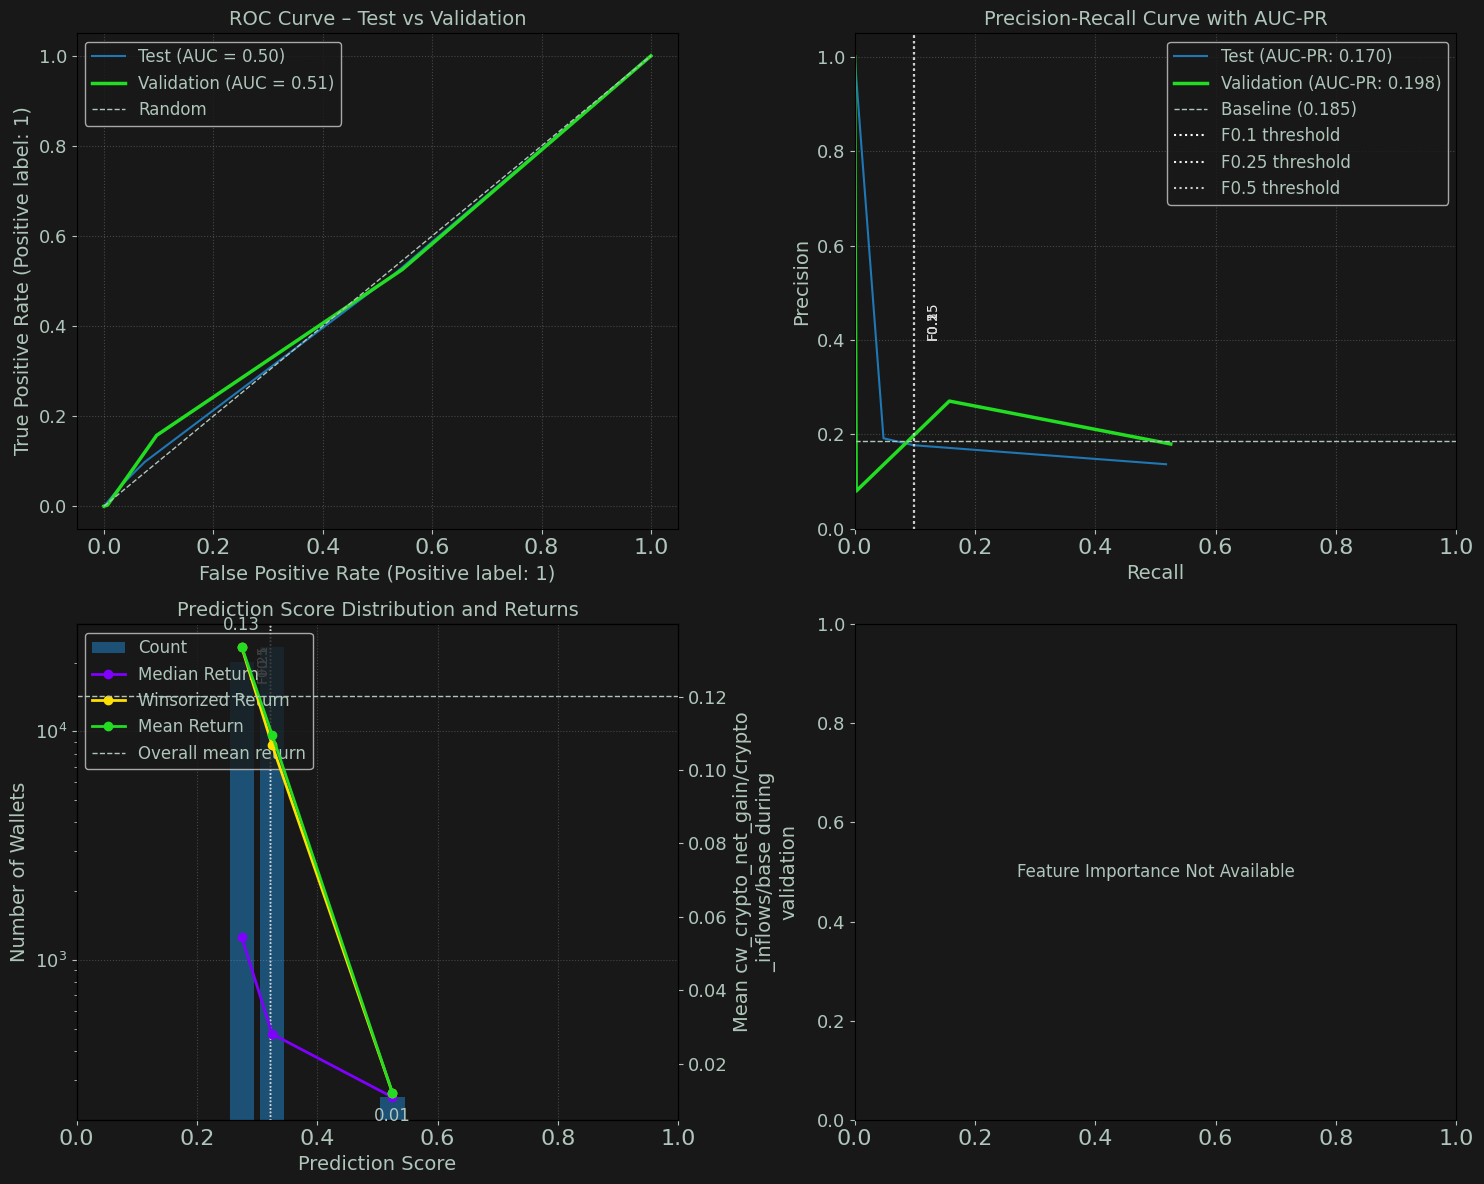

In [3]:
# no filters
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[14/Aug/25 18:03:30] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:30] WARNING [3429574254.<module>:6]                 0: 2024-06-04
[14/Aug/25 18:03:30] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:30] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0814-163541/output/model.tar.gz
Test Samples:             37,062
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.553  |  0.676
Val Accuracy:               0.843  |  0.830
Val Precision:              0.054  |  0.418
Val Recall:                 0.142  |  0.348
Val F1 Score:               0.078  |  0.380

Validation Retur

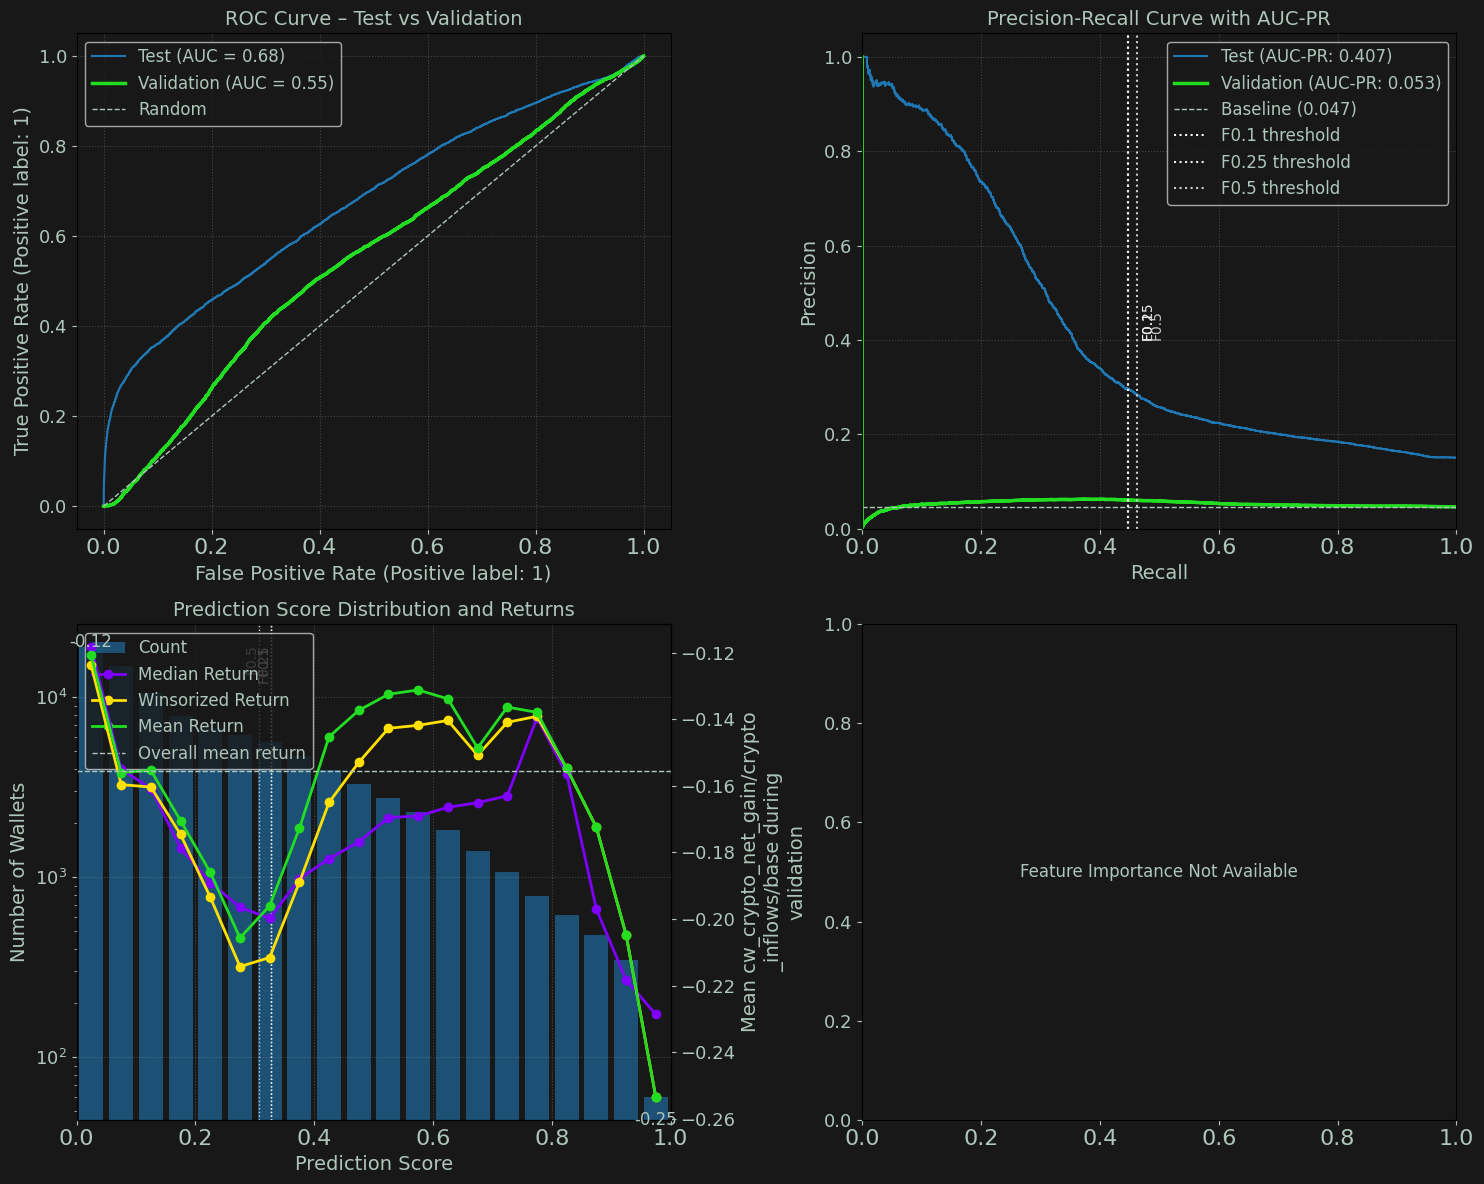

[14/Aug/25 18:03:31] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:31] WARNING [3429574254.<module>:6]                 60: 2024-08-03
[14/Aug/25 18:03:31] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:31] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0814-163541/output/model.tar.gz
Test Samples:             42,436
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.569  |  0.649
Val Accuracy:               0.713  |  0.810
Val Precision:              0.217  |  0.298
Val Recall:                 0.262  |  0.346
Val F1 Score:               0.237  |  0.320

Validation 

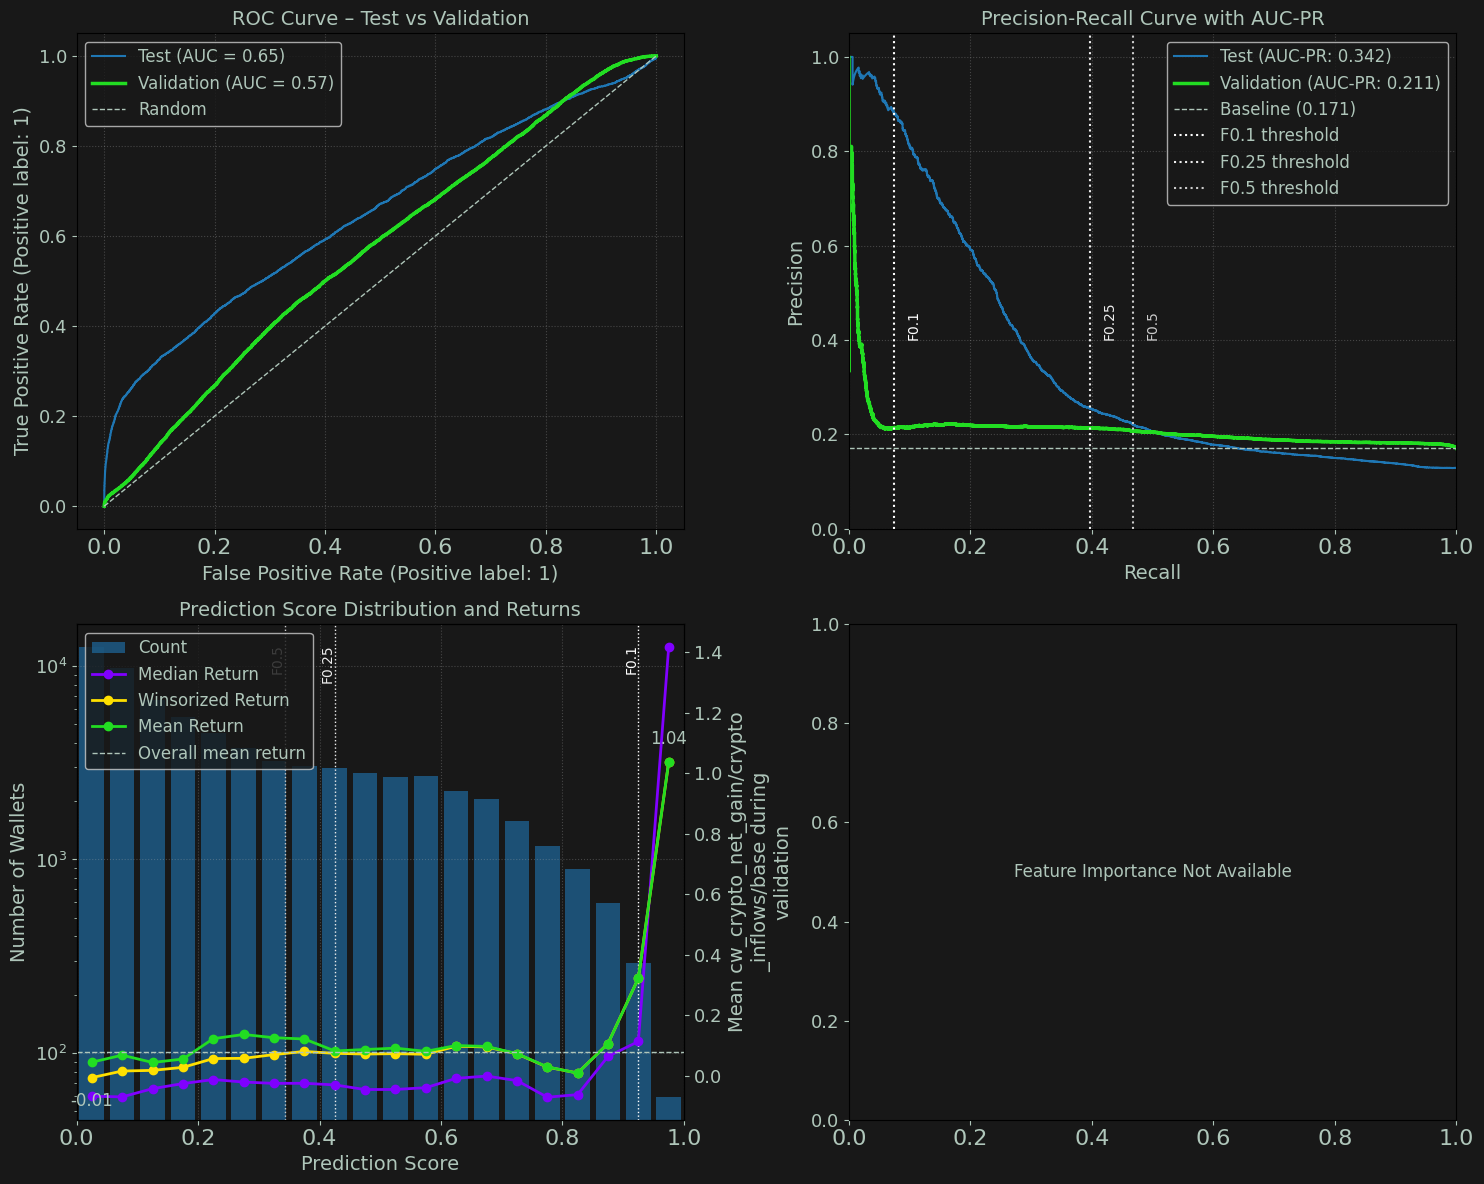

[14/Aug/25 18:03:32] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:32] WARNING [3429574254.<module>:6]                 120: 2024-10-02
[14/Aug/25 18:03:32] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:32] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0814-163541/output/model.tar.gz
Test Samples:             39,432
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.457  |  0.594
Val Accuracy:               0.603  |  0.769
Val Precision:              0.234  |  0.125
Val Recall:                 0.156  |  0.330
Val F1 Score:               0.188  |  0.181

Validati

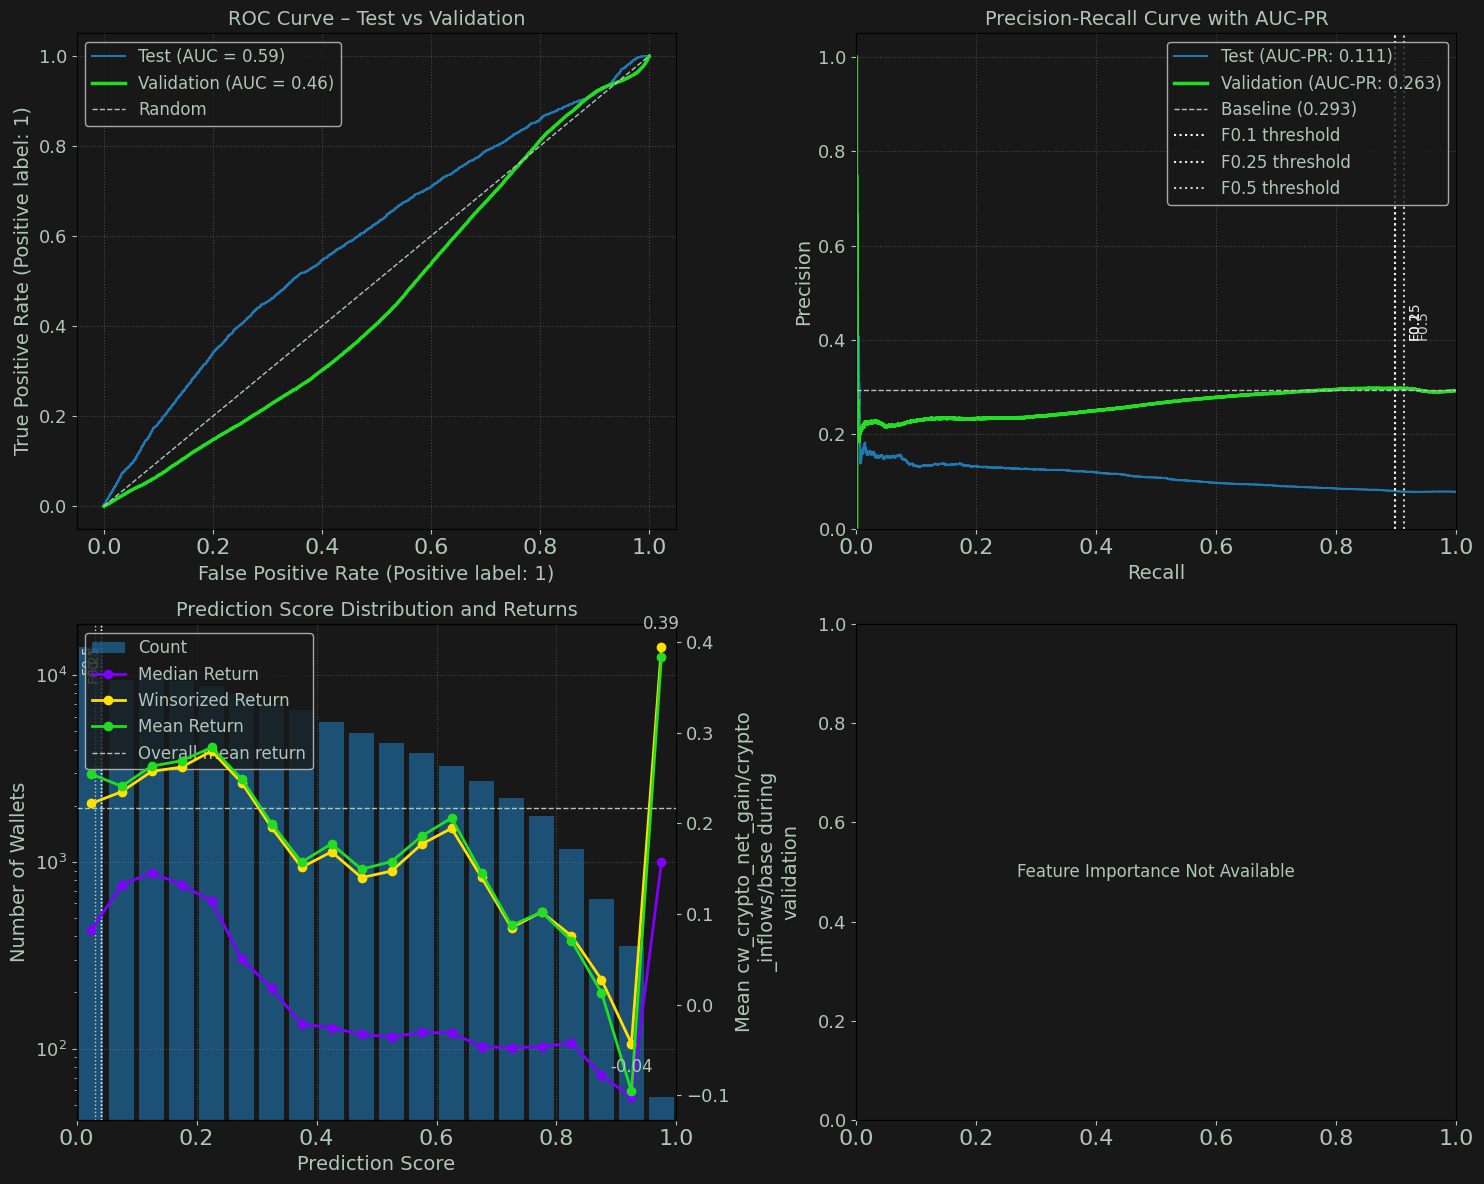

[14/Aug/25 18:03:32] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:32] WARNING [3429574254.<module>:6]                 180: 2024-12-01
[14/Aug/25 18:03:32] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:32] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0814-163541/output/model.tar.gz
Test Samples:             40,270
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.524  |  0.507
Val Accuracy:               0.618  |  0.276
Val Precision:              0.081  |  0.177
Val Recall:                 0.363  |  0.864
Val F1 Score:               0.133  |  0.294

Validatio

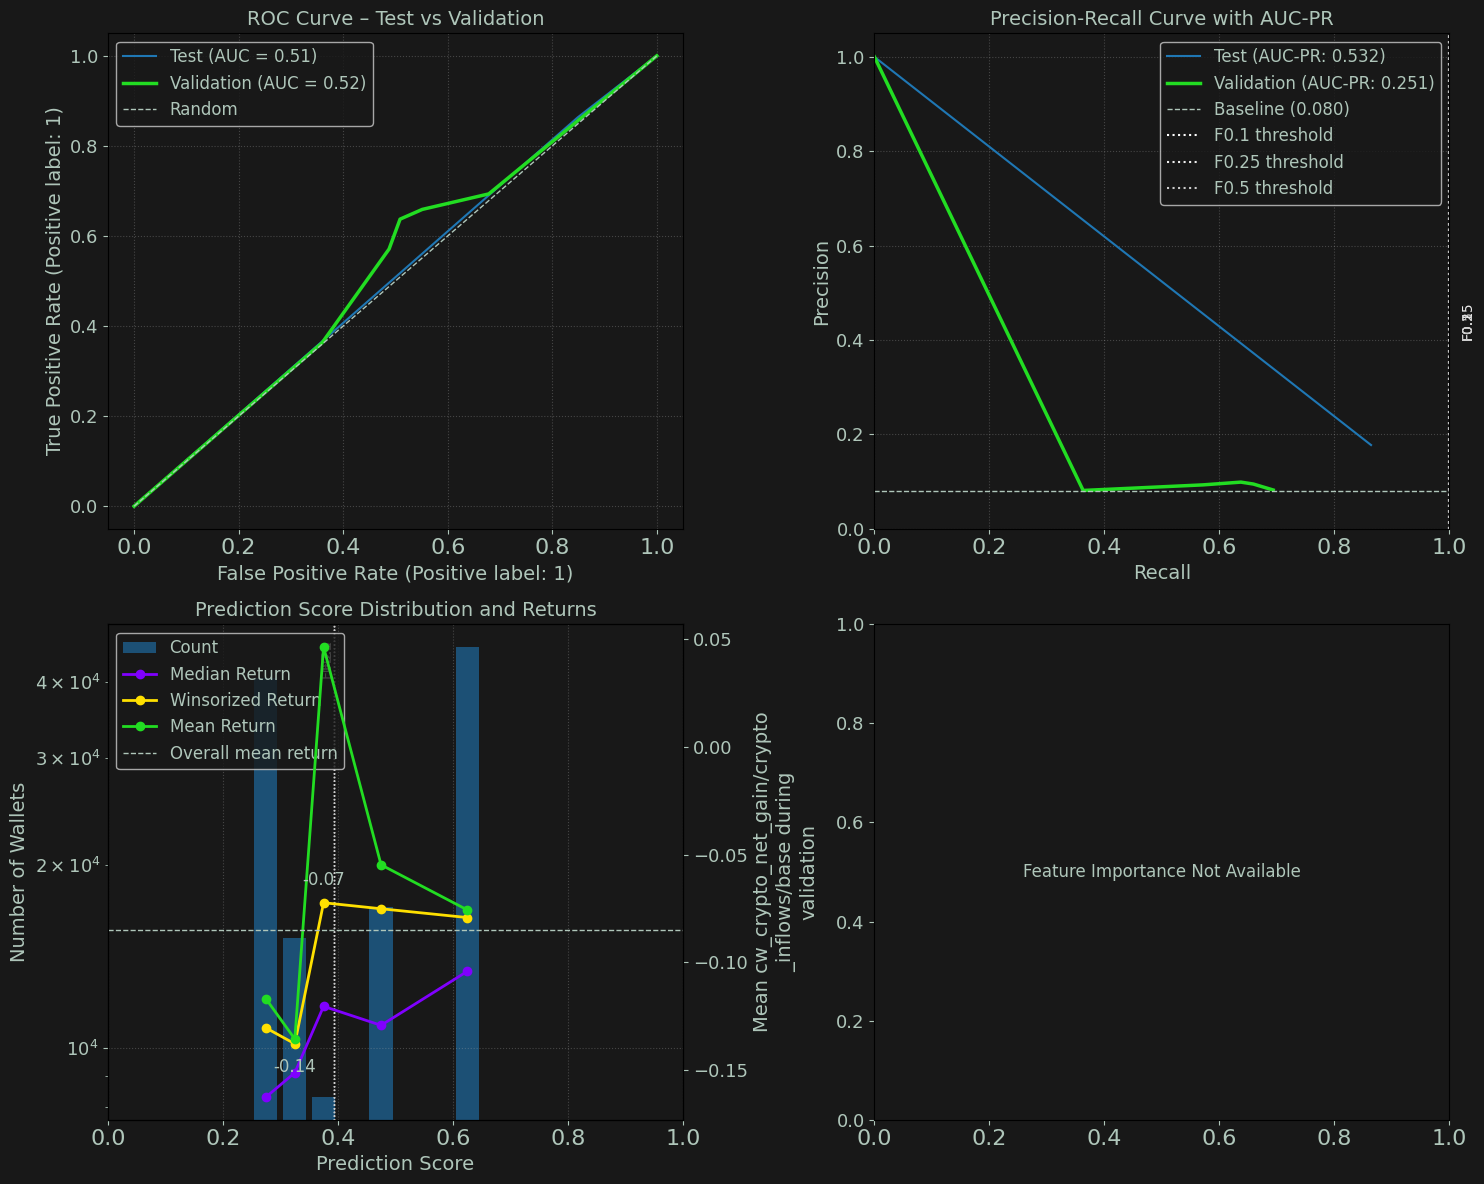

[14/Aug/25 18:03:33] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:33] WARNING [3429574254.<module>:6]                 240: 2025-01-30
[14/Aug/25 18:03:33] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:33] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0814-163541/output/model.tar.gz
Test Samples:             45,080
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.640  |  0.543
Val Accuracy:               0.976  |  0.821
Val Precision:              0.015  |  0.201
Val Recall:                 0.005  |  0.005
Val F1 Score:               0.007  |  0.011

Validation

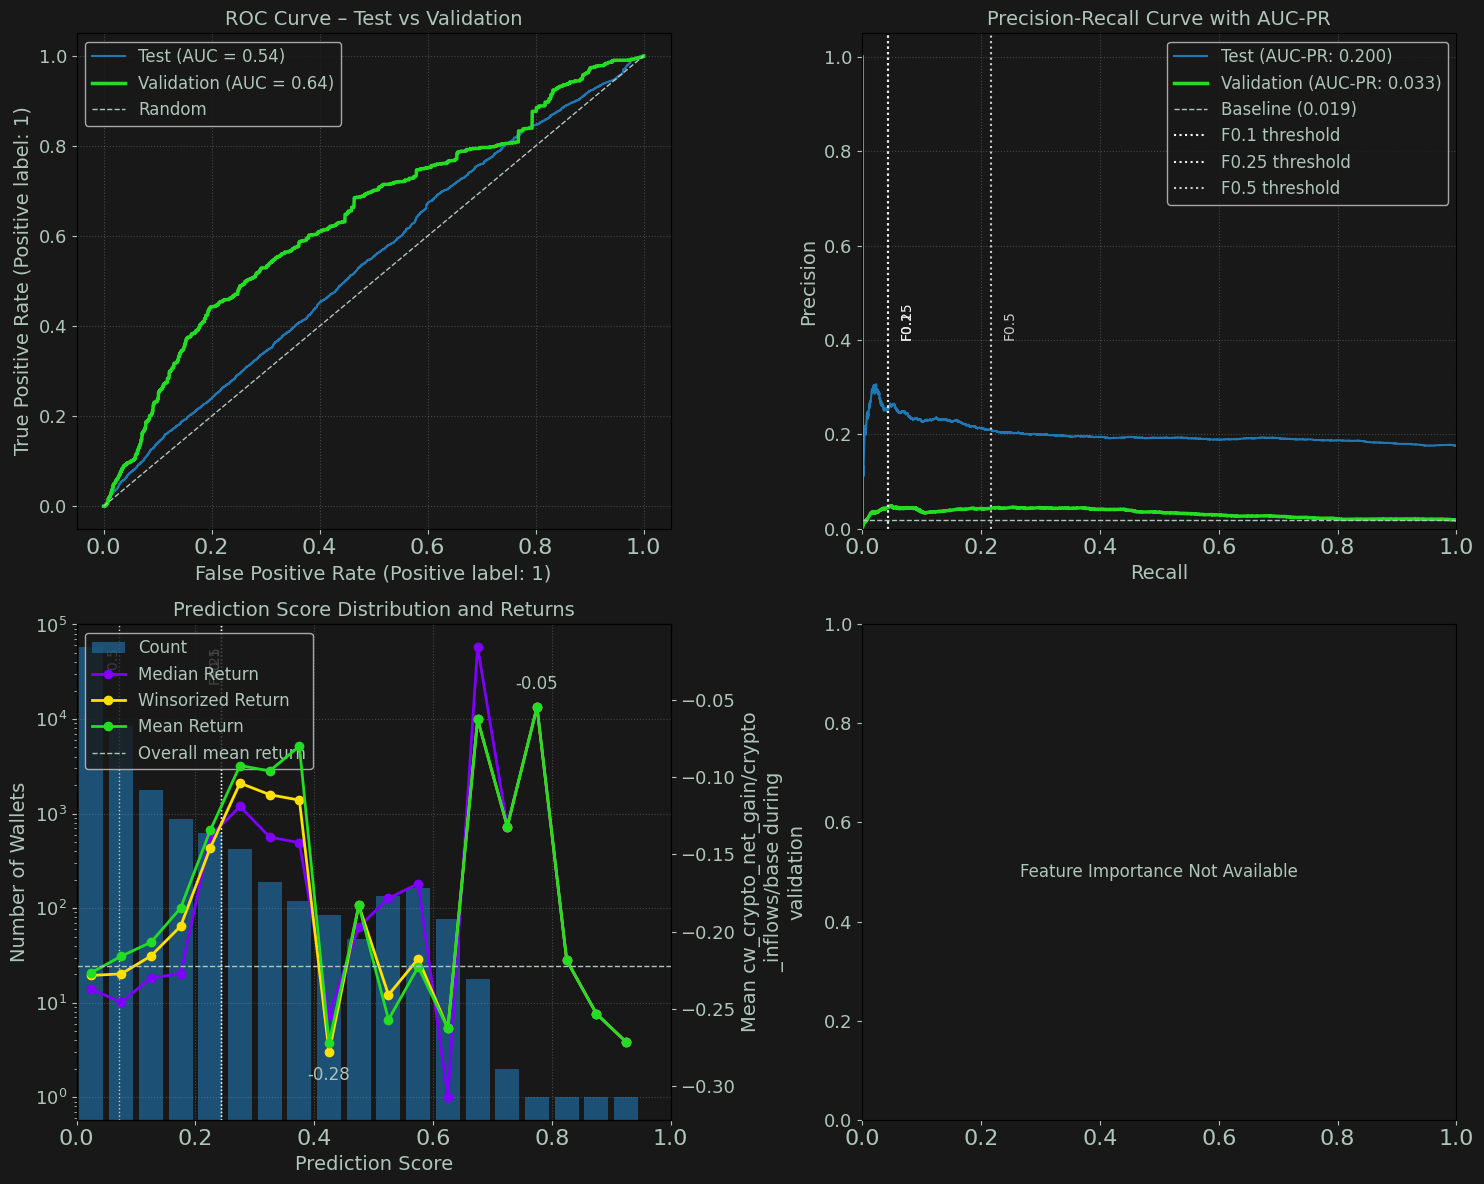

[14/Aug/25 18:03:34] INFO [3429574254.<module>:5] -------------------------------------------------
[14/Aug/25 18:03:34] WARNING [3429574254.<module>:6]                 300: 2025-03-31
[14/Aug/25 18:03:34] INFO [3429574254.<module>:7] -------------------------------------------------
[14/Aug/25 18:03:34] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0814-163541/output/model.tar.gz
Test Samples:             45,393
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.451  |  0.505
Val Accuracy:               0.815  |  0.860
Val Precision:              0.000  |  0.000
Val Recall:                 0.000  |  0.000
Val F1 Score:               0.000  |  0.000

Validatio

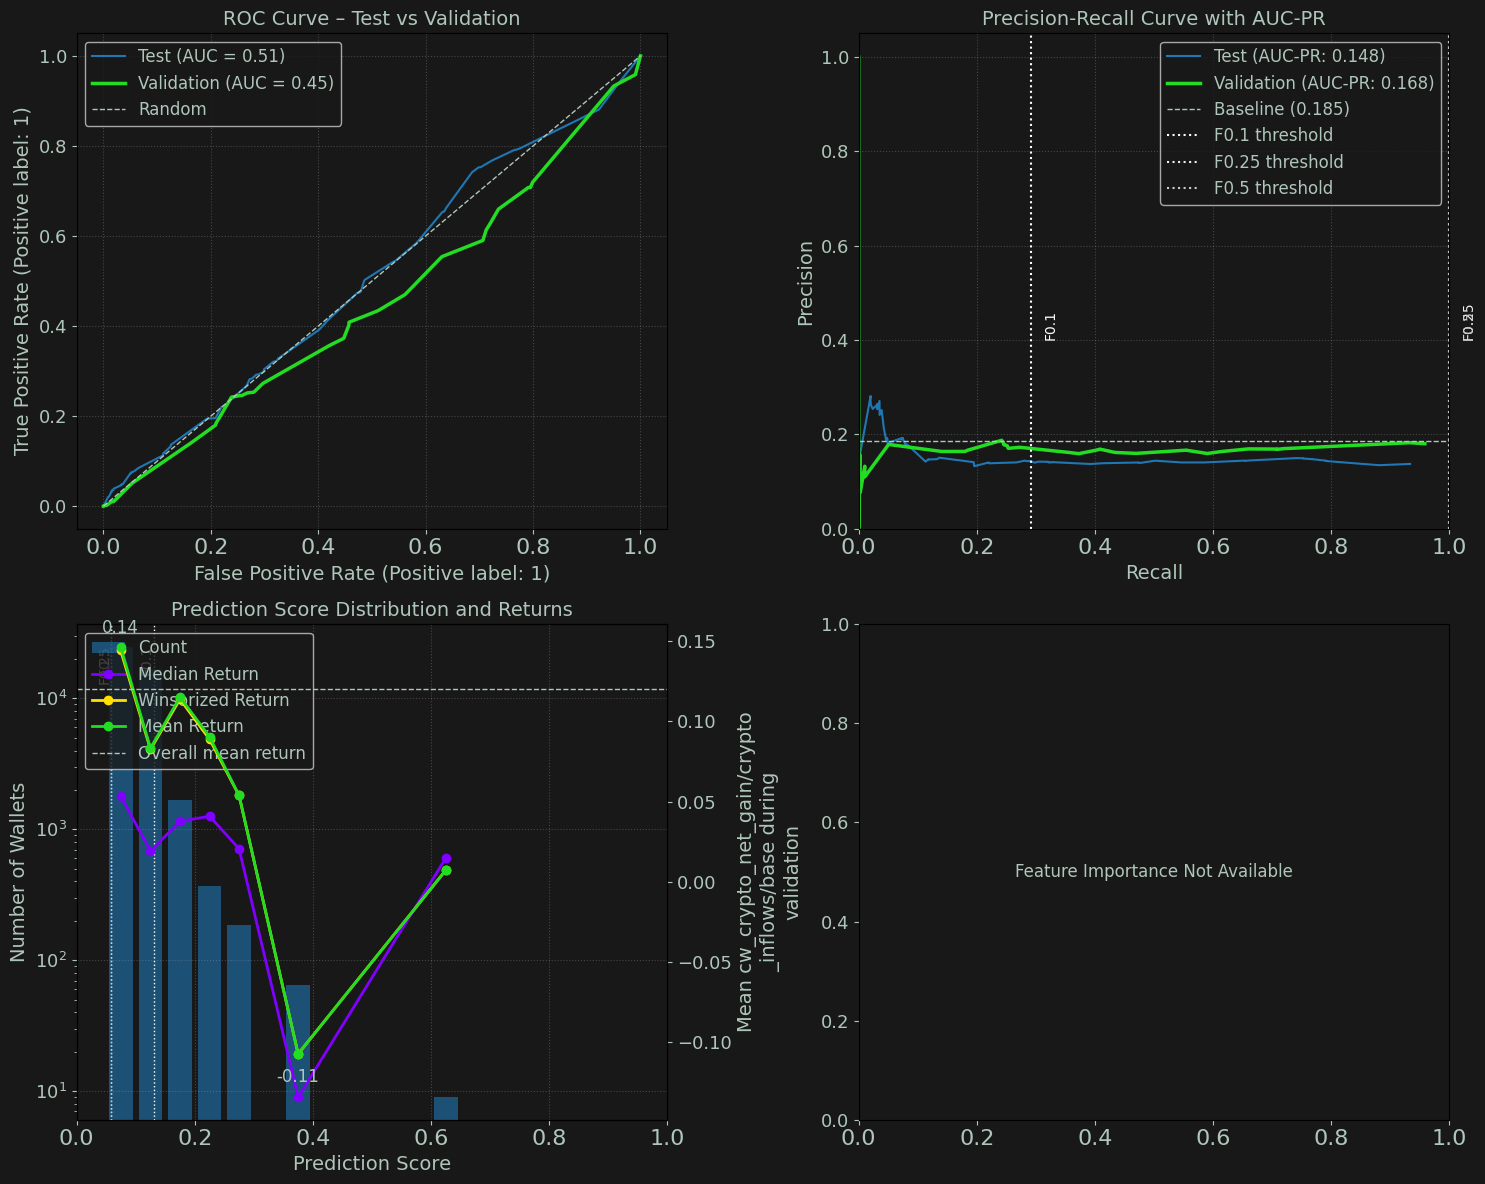

In [ ]:
# w filters
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[13/Aug/25 18:19:44] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:44] WARNING [951596577.<module>:6]                 0: 2024-06-04
[13/Aug/25 18:19:44] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:44] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-175145/output/model.tar.gz
Test Samples:             52,089
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.542  |  0.723
Val Accuracy:               0.819  |  0.831
Val Precision:              0.061  |  0.409
Val Recall:                 0.199  |  0.401
Val F1 Score:               0.093  |  0.405

Validation Returns 

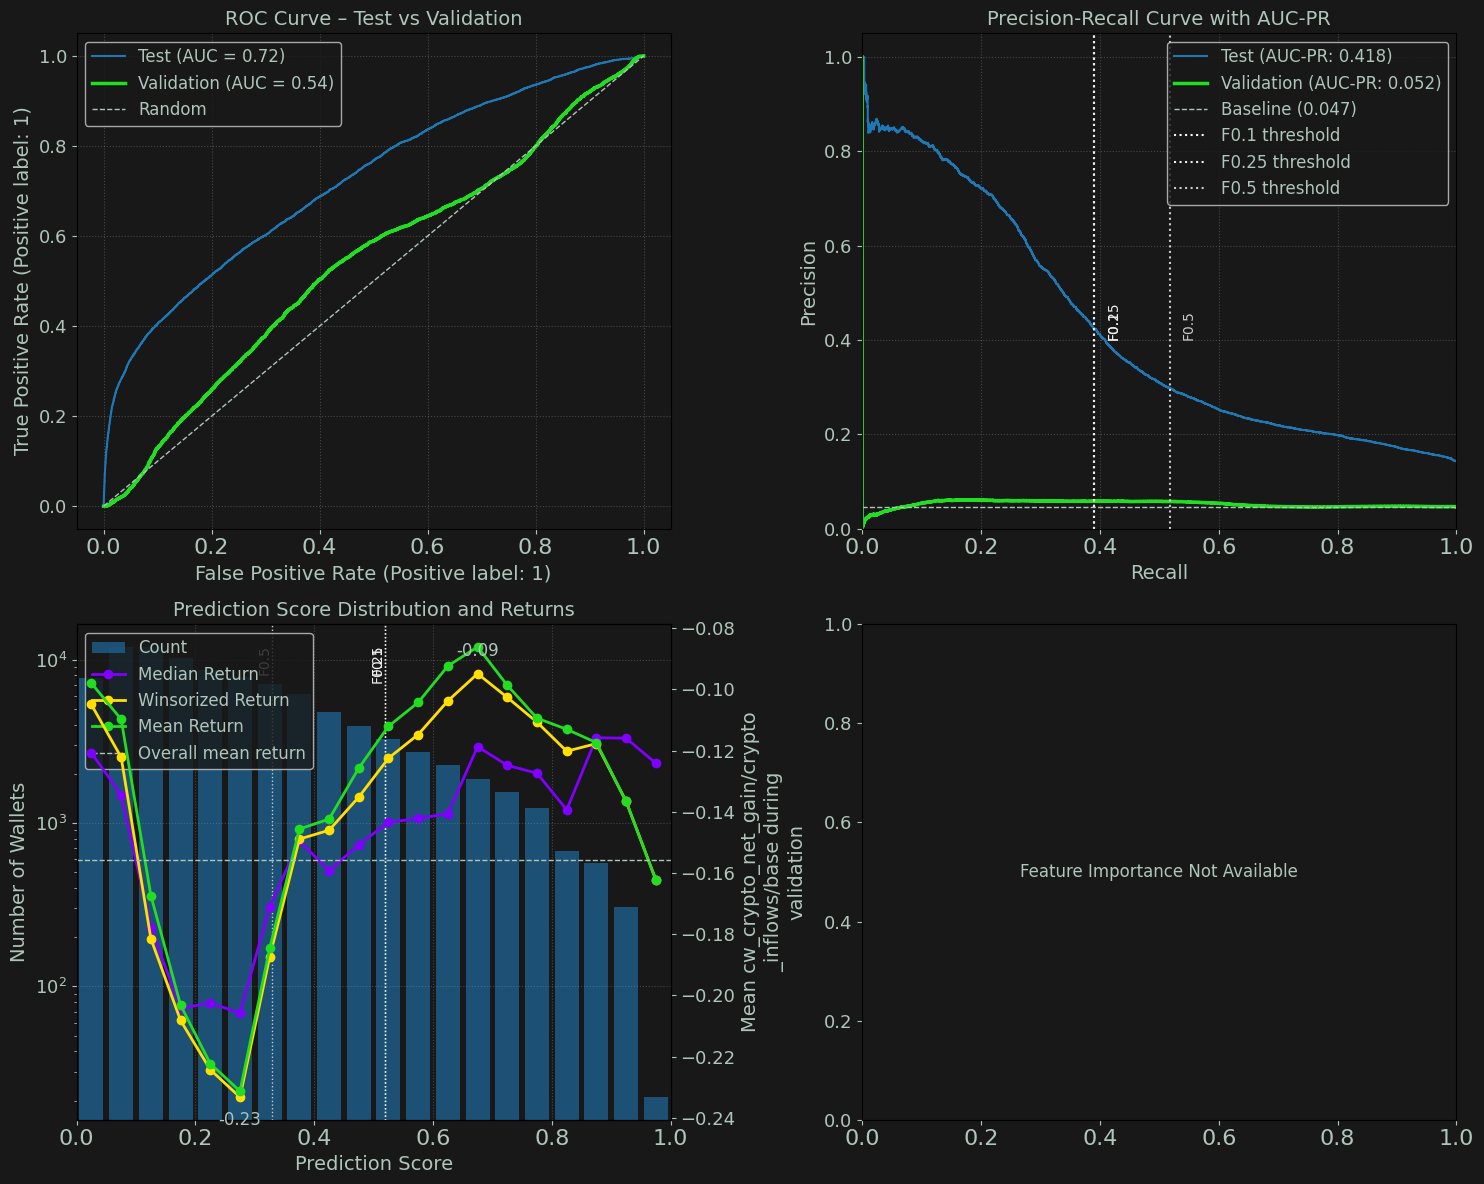

[13/Aug/25 18:19:45] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:45] WARNING [951596577.<module>:6]                 60: 2024-08-03
[13/Aug/25 18:19:45] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:45] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-175145/output/model.tar.gz
Test Samples:             62,474
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.533  |  0.651
Val Accuracy:               0.790  |  0.826
Val Precision:              0.260  |  0.333
Val Recall:                 0.125  |  0.365
Val F1 Score:               0.169  |  0.348

Validation Ret

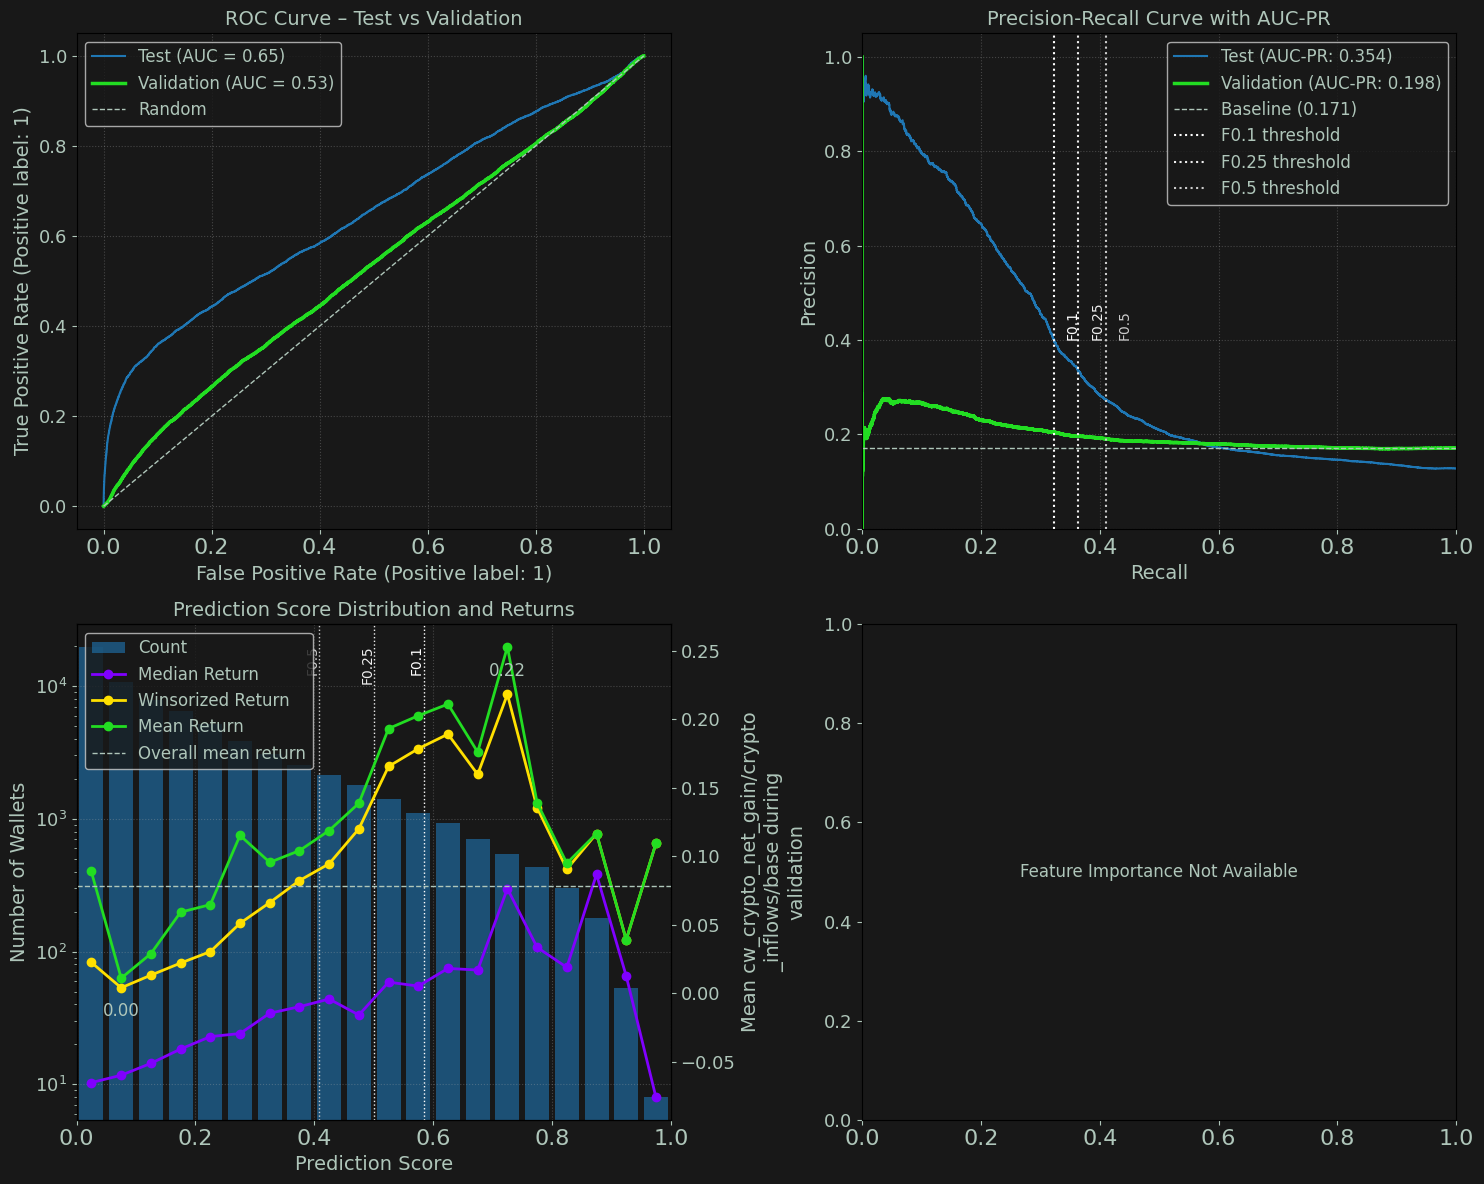

[13/Aug/25 18:19:45] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:45] WARNING [951596577.<module>:6]                 120: 2024-10-02
[13/Aug/25 18:19:45] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:45] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-175145/output/model.tar.gz
Test Samples:             69,591
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.419  |  0.607
Val Accuracy:               0.631  |  0.836
Val Precision:              0.178  |  0.367
Val Recall:                 0.072  |  0.289
Val F1 Score:               0.103  |  0.323

Validation 

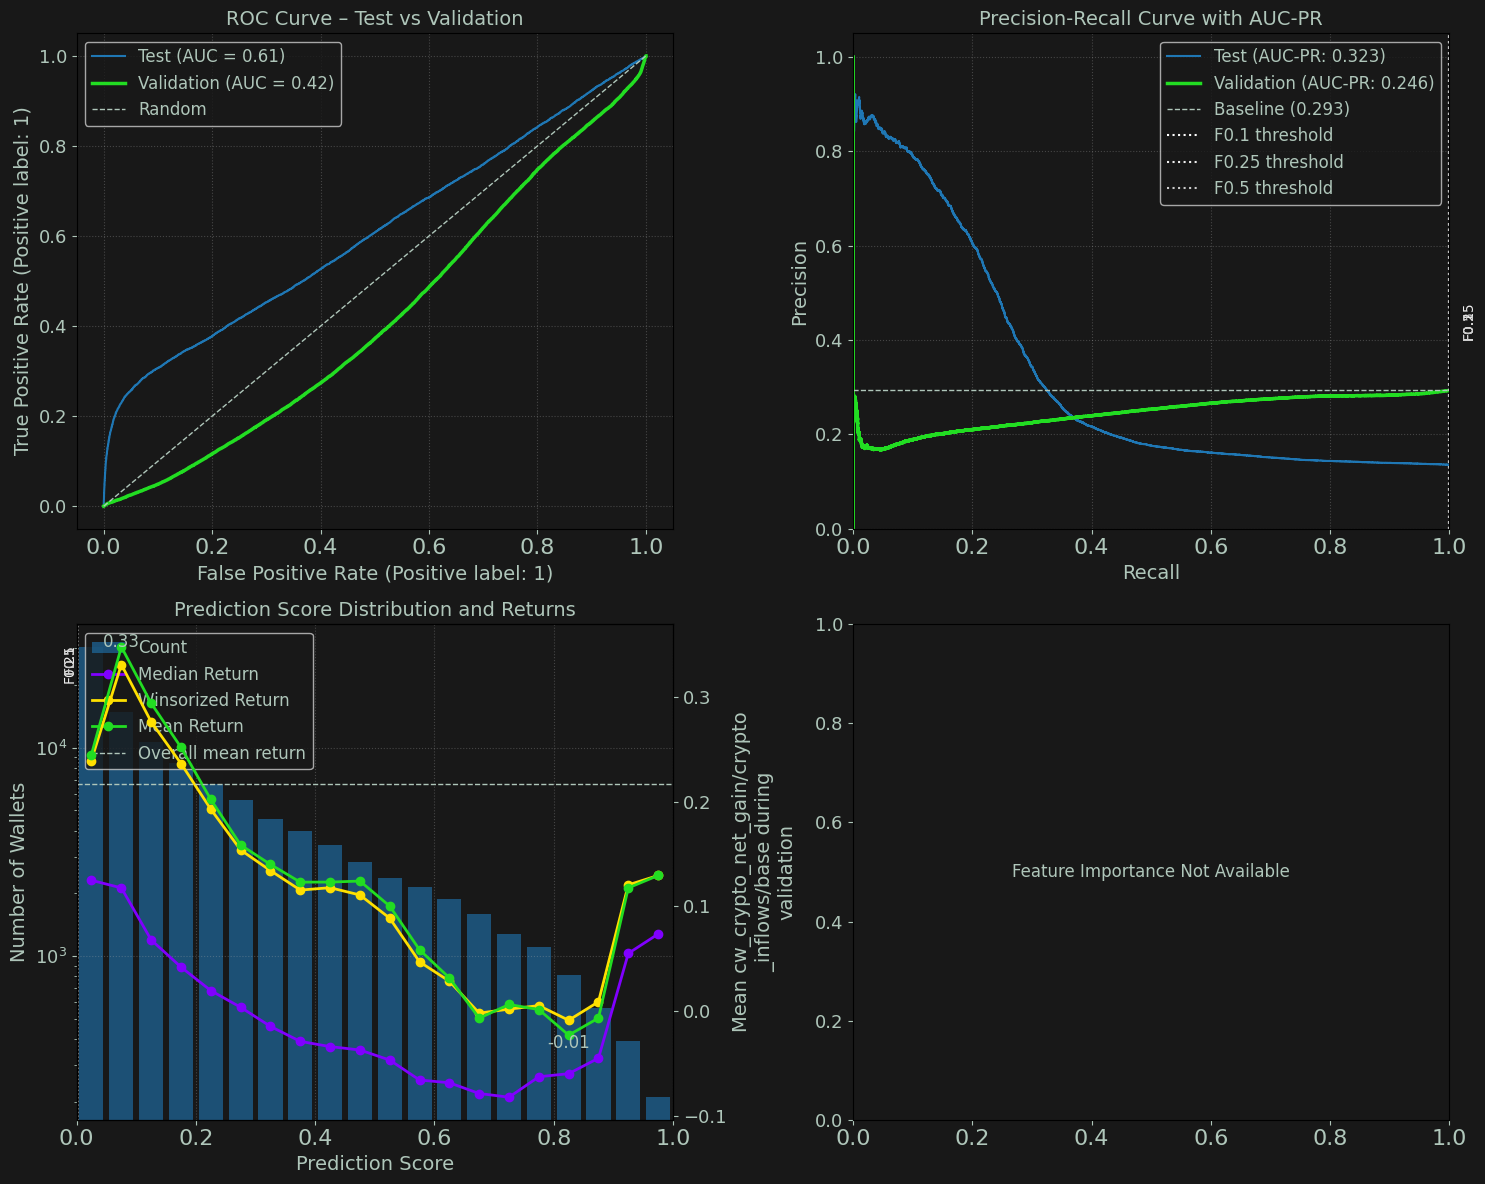

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 180: 2024-12-01
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-175145/output/model.tar.gz
Test Samples:             82,008
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.521  |  0.556
Val Accuracy:               0.830  |  0.797
Val Precision:              0.088  |  0.341
Val Recall:                 0.118  |  0.213
Val F1 Score:               0.101  |  0.262

Validation R

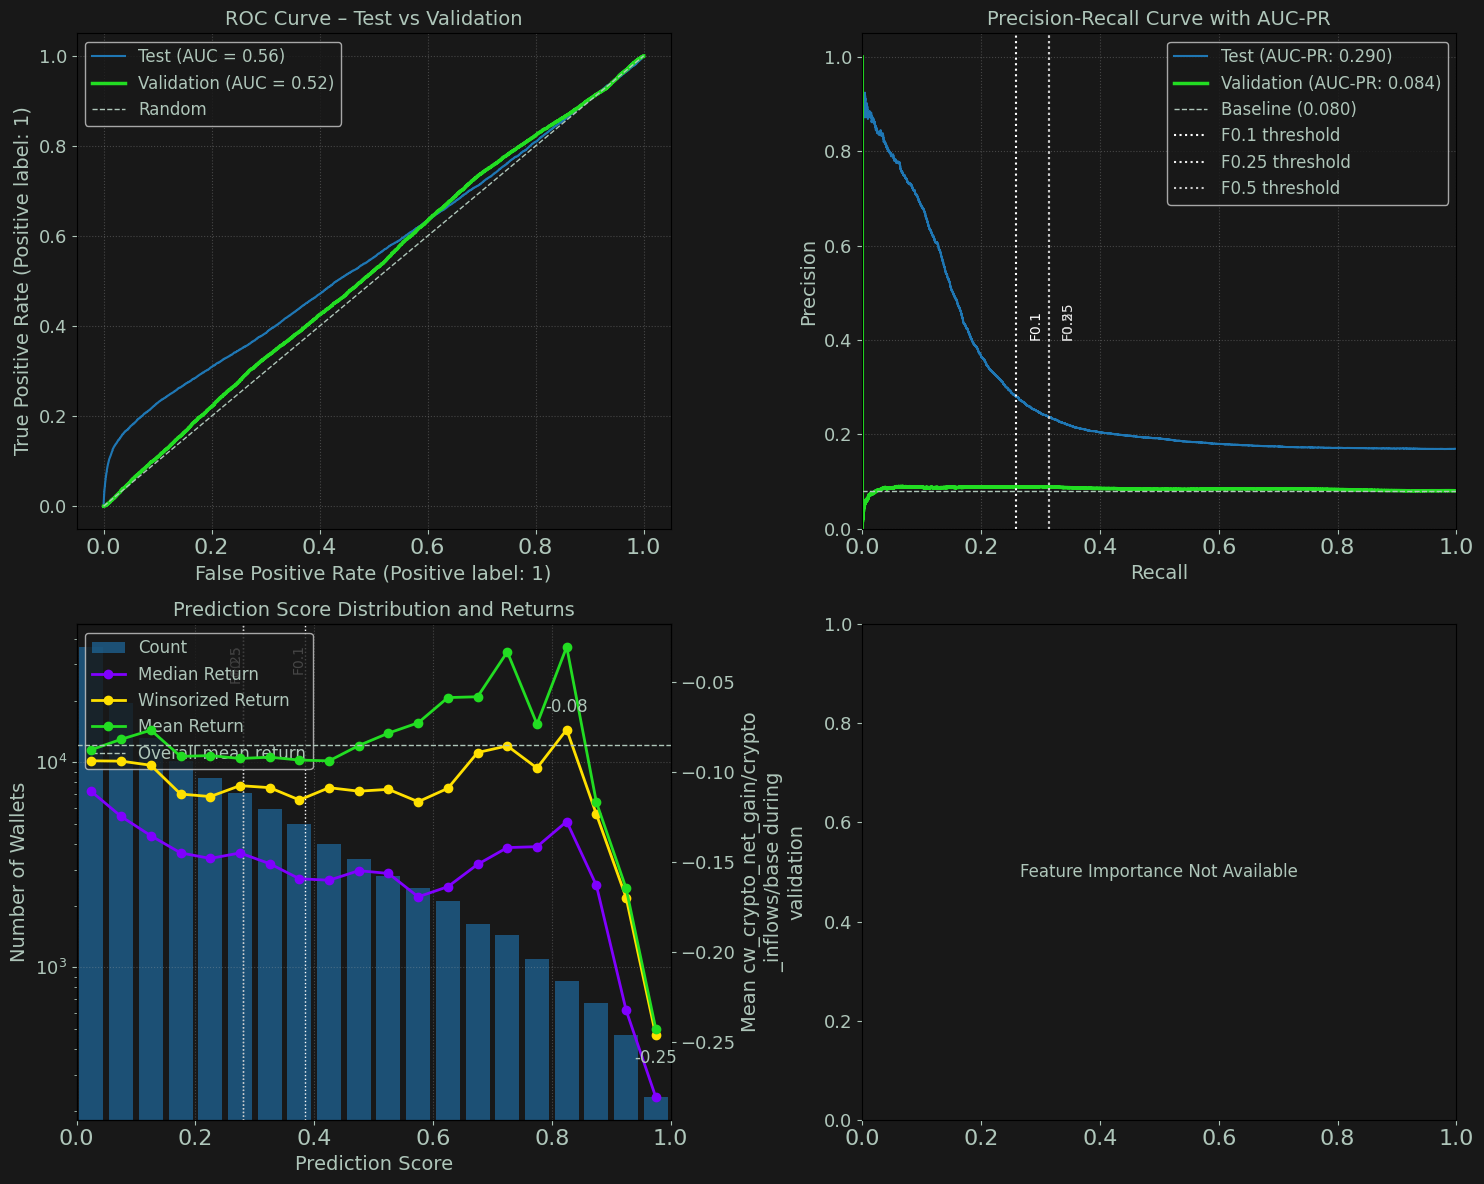

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 240: 2025-01-30
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-175145/output/model.tar.gz
Test Samples:             96,423
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.558  |  0.585
Val Accuracy:               0.951  |  0.789
Val Precision:              0.007  |  0.267
Val Recall:                 0.011  |  0.248
Val F1 Score:               0.009  |  0.257

Validation Re

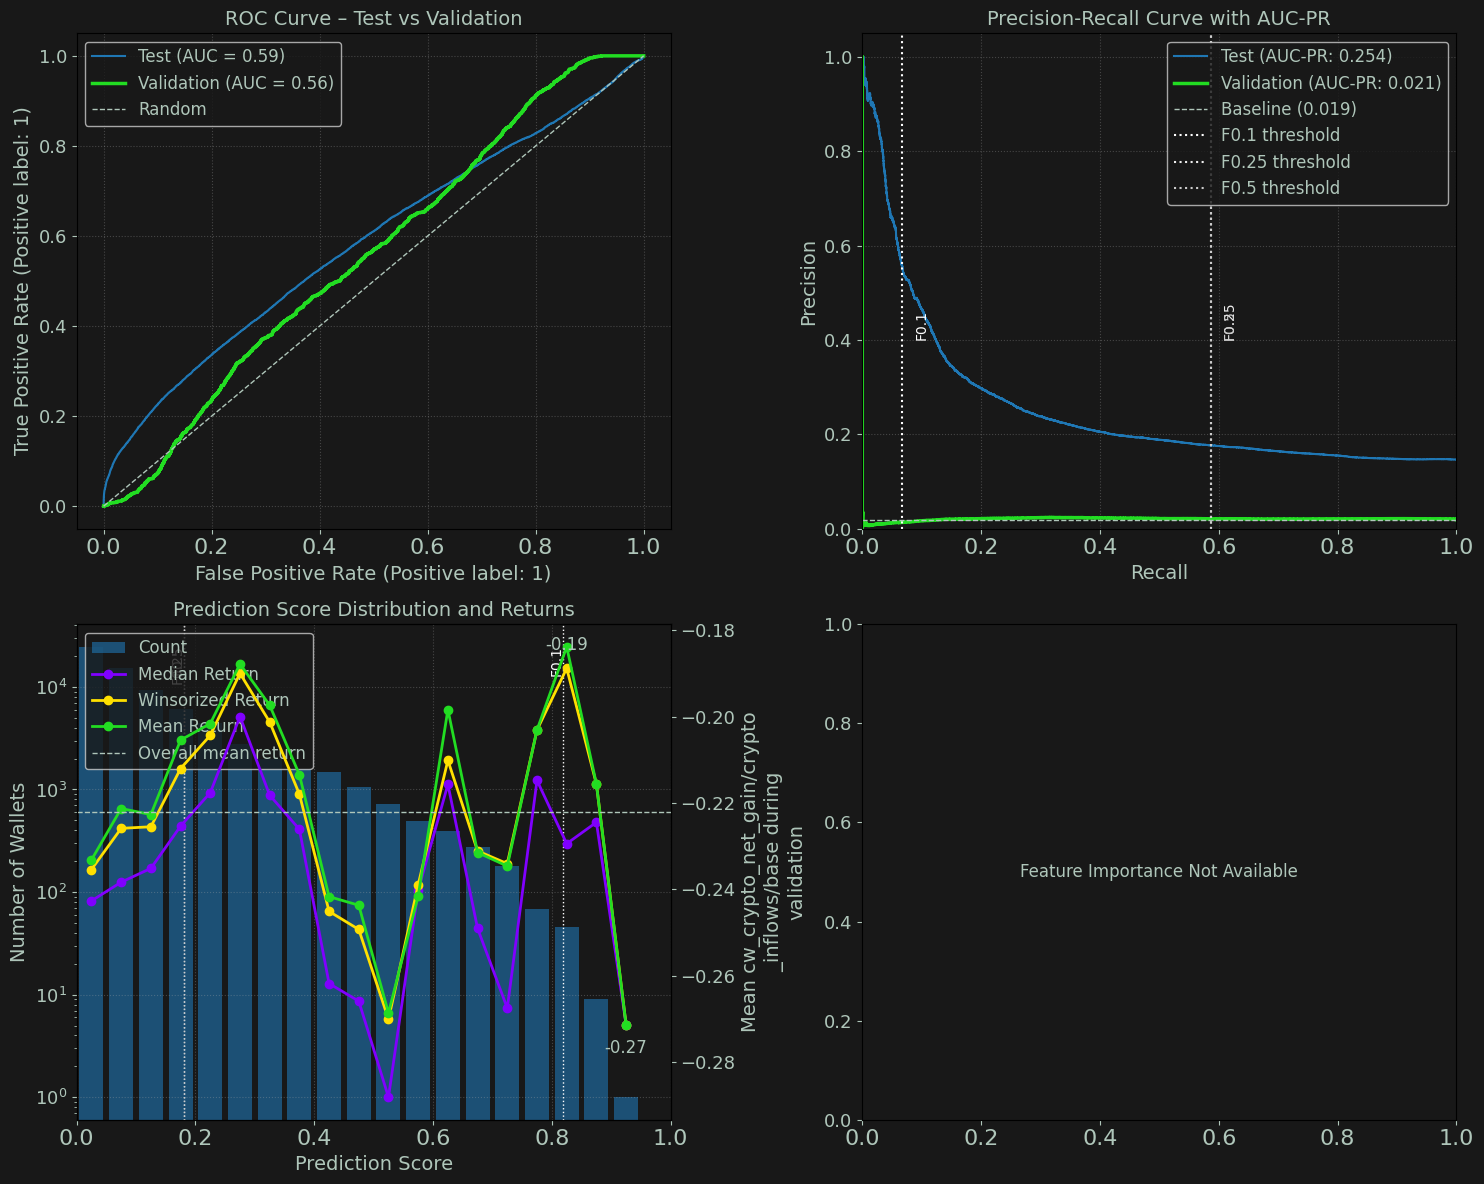

[13/Aug/25 18:19:46] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:46] WARNING [951596577.<module>:6]                 300: 2025-03-31
[13/Aug/25 18:19:46] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-175145/output/model.tar.gz
Test Samples:             98,144
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.537  |  0.529
Val Accuracy:               0.754  |  0.807
Val Precision:              0.255  |  0.237
Val Recall:                 0.171  |  0.179
Val F1 Score:               0.205  |  0.204

Validation R

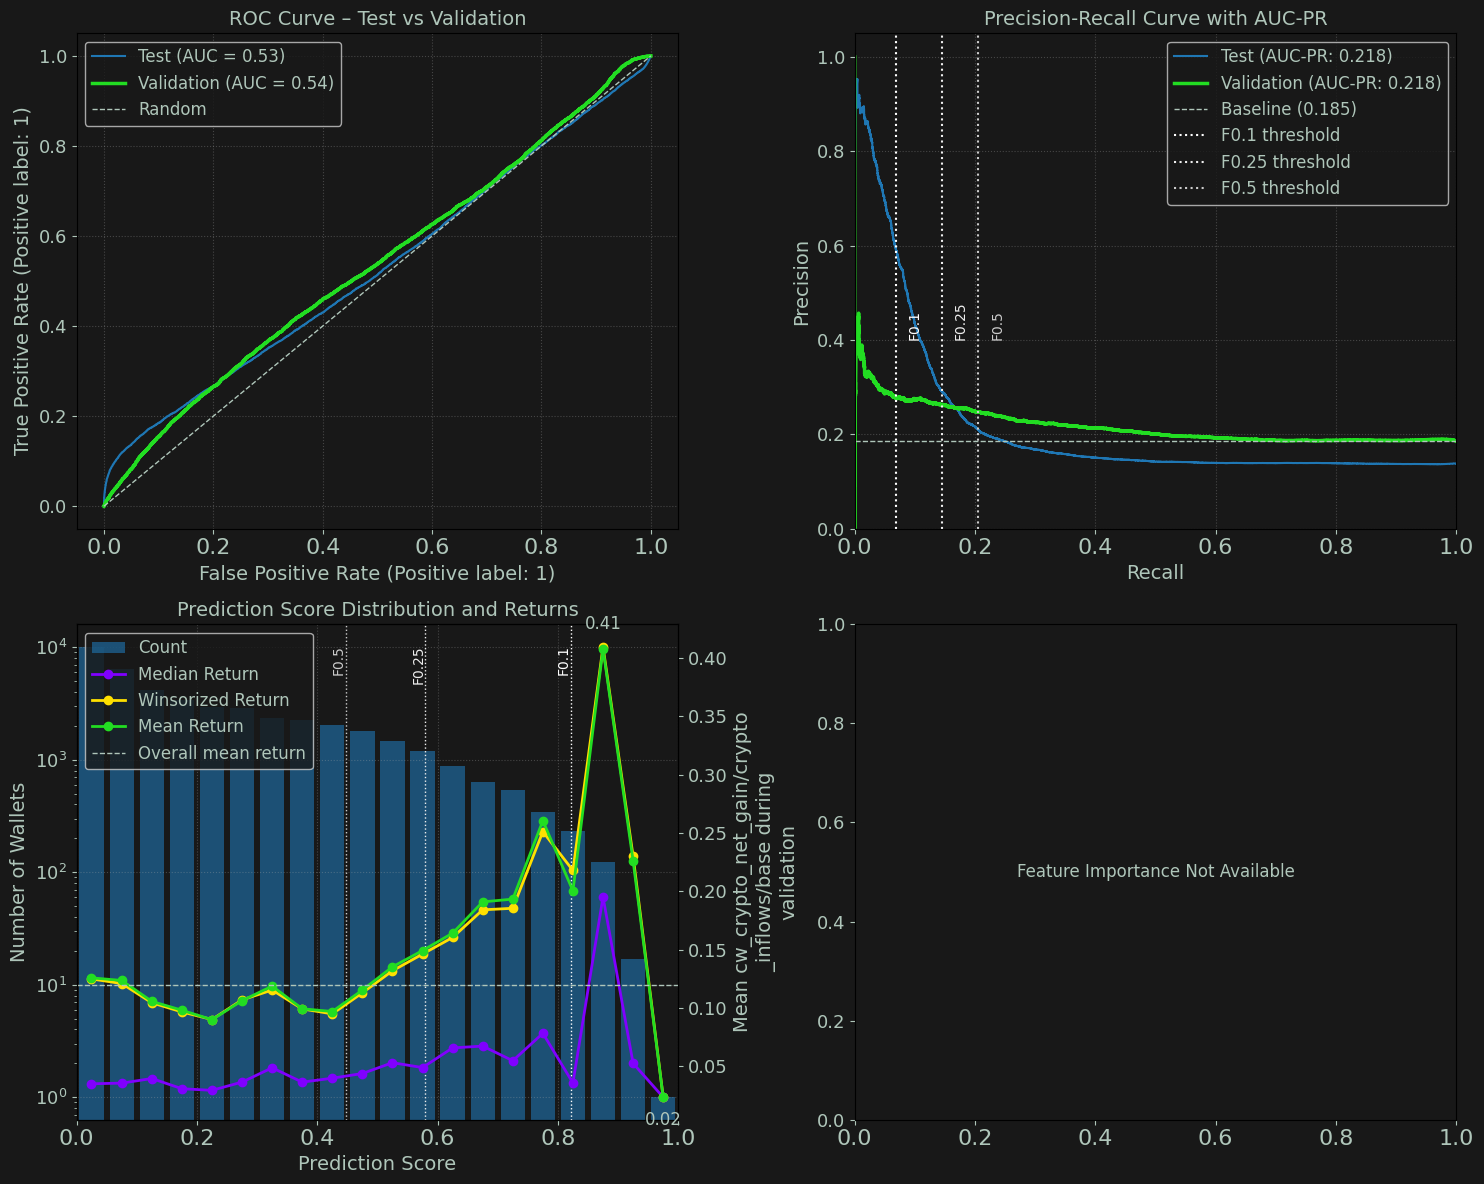

[13/Aug/25 18:19:47] INFO [951596577.<module>:5] -------------------------------------------------
[13/Aug/25 18:19:47] WARNING [951596577.<module>:6]                 360: 2025-05-30
[13/Aug/25 18:19:47] INFO [951596577.<module>:7] -------------------------------------------------
[13/Aug/25 18:19:47] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-175145/output/model.tar.gz
Test Samples:             87,938
Val Positive Samples:     6,688 (15.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.577  |  0.526
Val Accuracy:               0.827  |  0.842
Val Precision:              0.183  |  0.144
Val Recall:                 0.034  |  0.081
Val F1 Score:               0.057  |  0.104

Validation R

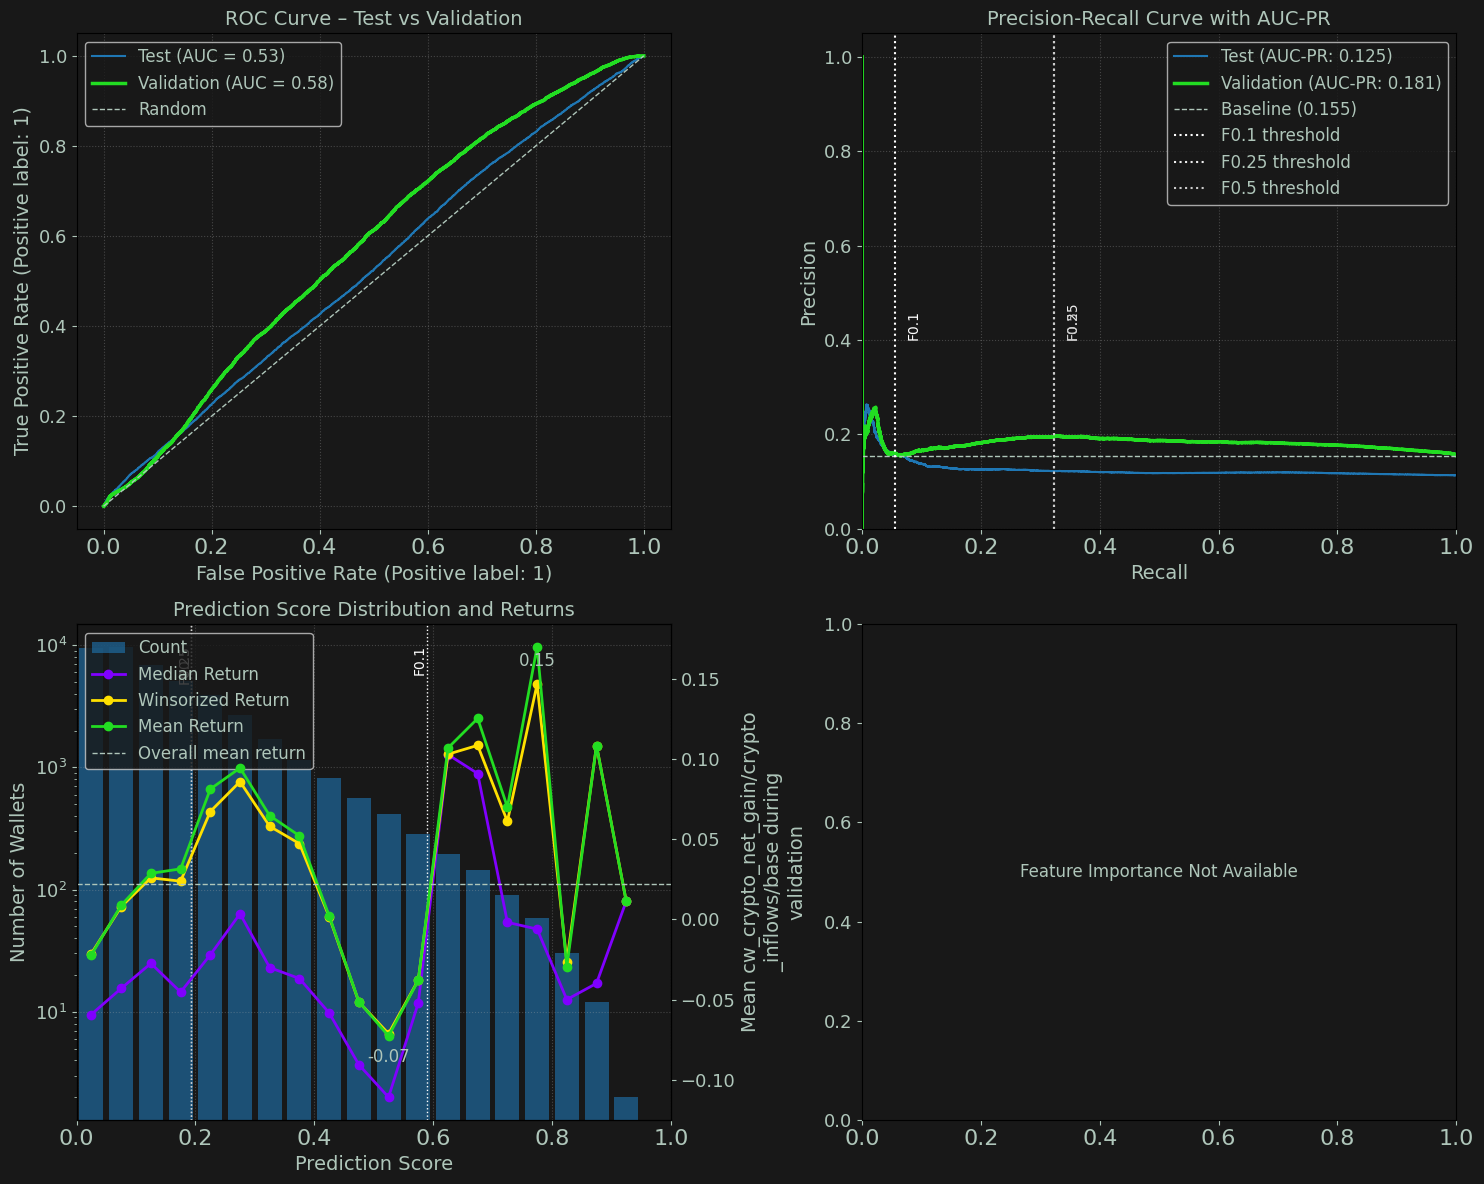

In [79]:
# 2 years less
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[13/Aug/25 17:44:17] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:17] WARNING [1138767417.<module>:5]                 0: 2024-06-04
[13/Aug/25 17:44:17] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:17] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh0/wscr-dda-956--sh0-0813-164642/output/model.tar.gz
Test Samples:             52,089
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.666
Val Accuracy:               0.716  |  0.819
Val Precision:              0.042  |  0.374
Val Recall:                 0.236  |  0.389
Val F1 Score:               0.072  |  0.381

Validation Retur

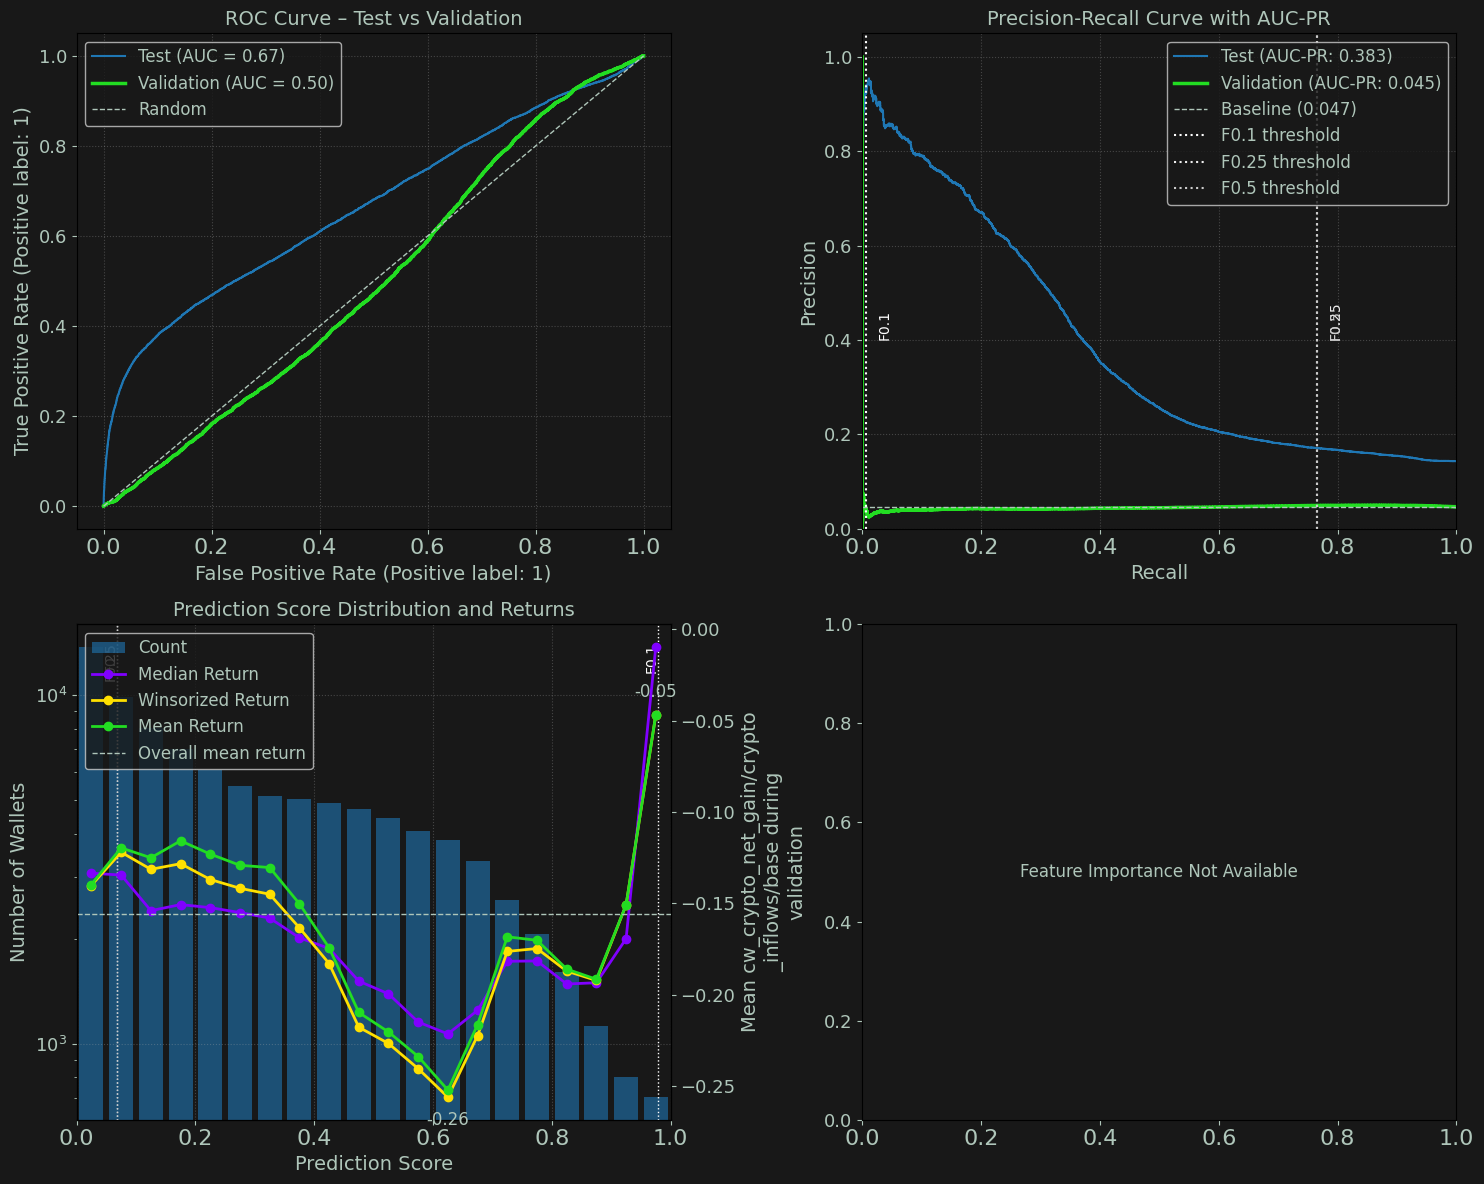

[13/Aug/25 17:44:17] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:17] WARNING [1138767417.<module>:5]                 60: 2024-08-03
[13/Aug/25 17:44:17] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:17] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh60/wscr-dda-956--sh60-0813-164642/output/model.tar.gz
Test Samples:             62,474
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.639
Val Accuracy:               0.755  |  0.808
Val Precision:              0.153  |  0.293
Val Recall:                 0.097  |  0.359
Val F1 Score:               0.119  |  0.322

Validation 

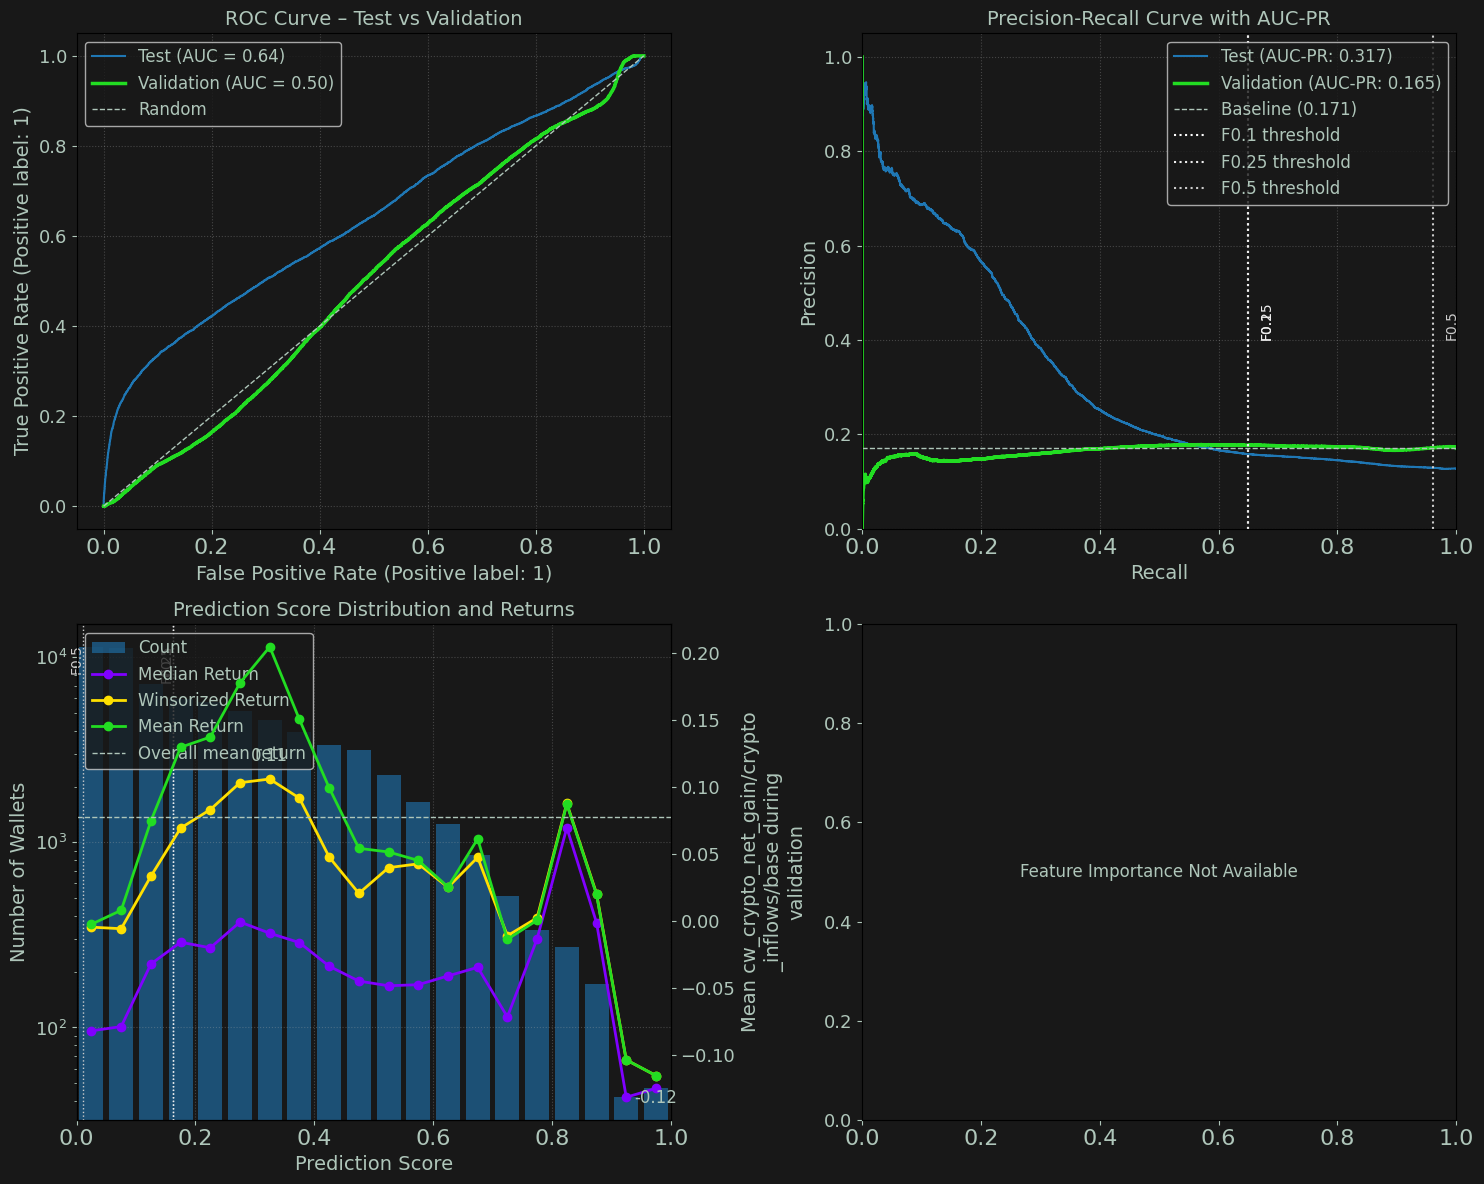

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 120: 2024-10-02
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh120/wscr-dda-956--sh120-0813-164642/output/model.tar.gz
Test Samples:             69,591
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.500  |  0.654
Val Accuracy:               0.663  |  0.826
Val Precision:              0.238  |  0.341
Val Recall:                 0.069  |  0.302
Val F1 Score:               0.107  |  0.320

Validati

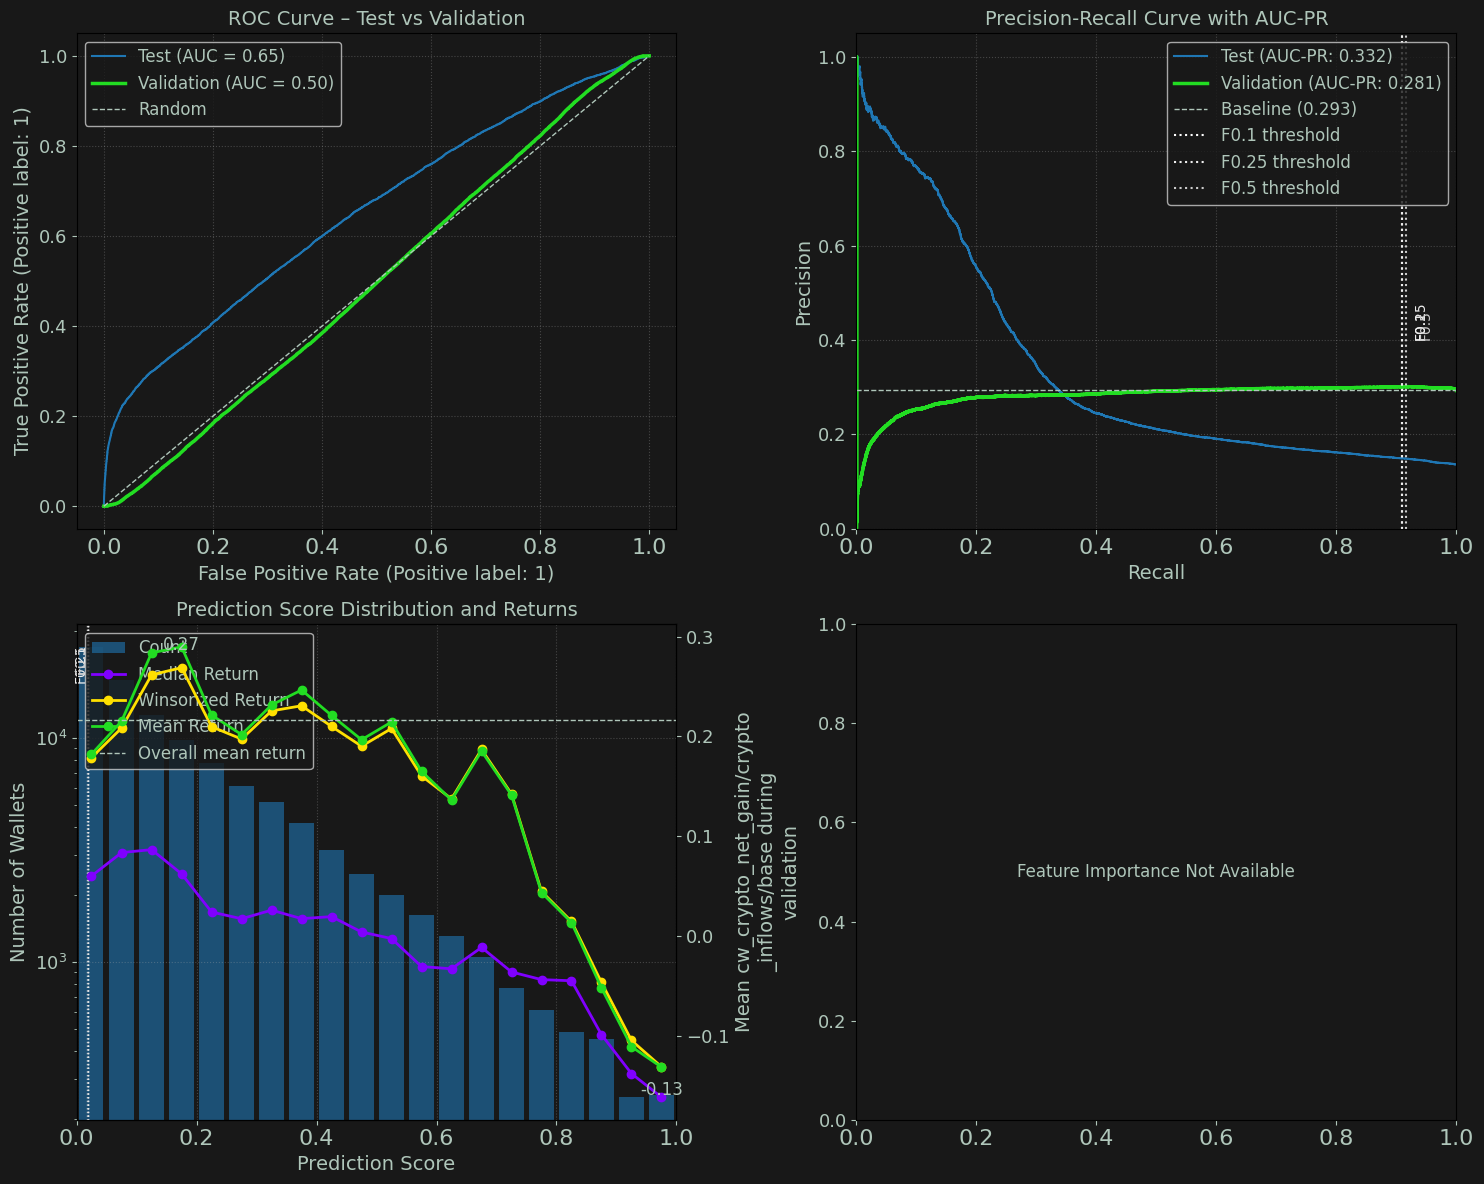

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 180: 2024-12-01
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh180/wscr-dda-956--sh180-0813-164642/output/model.tar.gz
Test Samples:             82,008
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.530  |  0.497
Val Accuracy:               0.734  |  0.742
Val Precision:              0.104  |  0.206
Val Recall:                 0.304  |  0.182
Val F1 Score:               0.155  |  0.193

Validatio

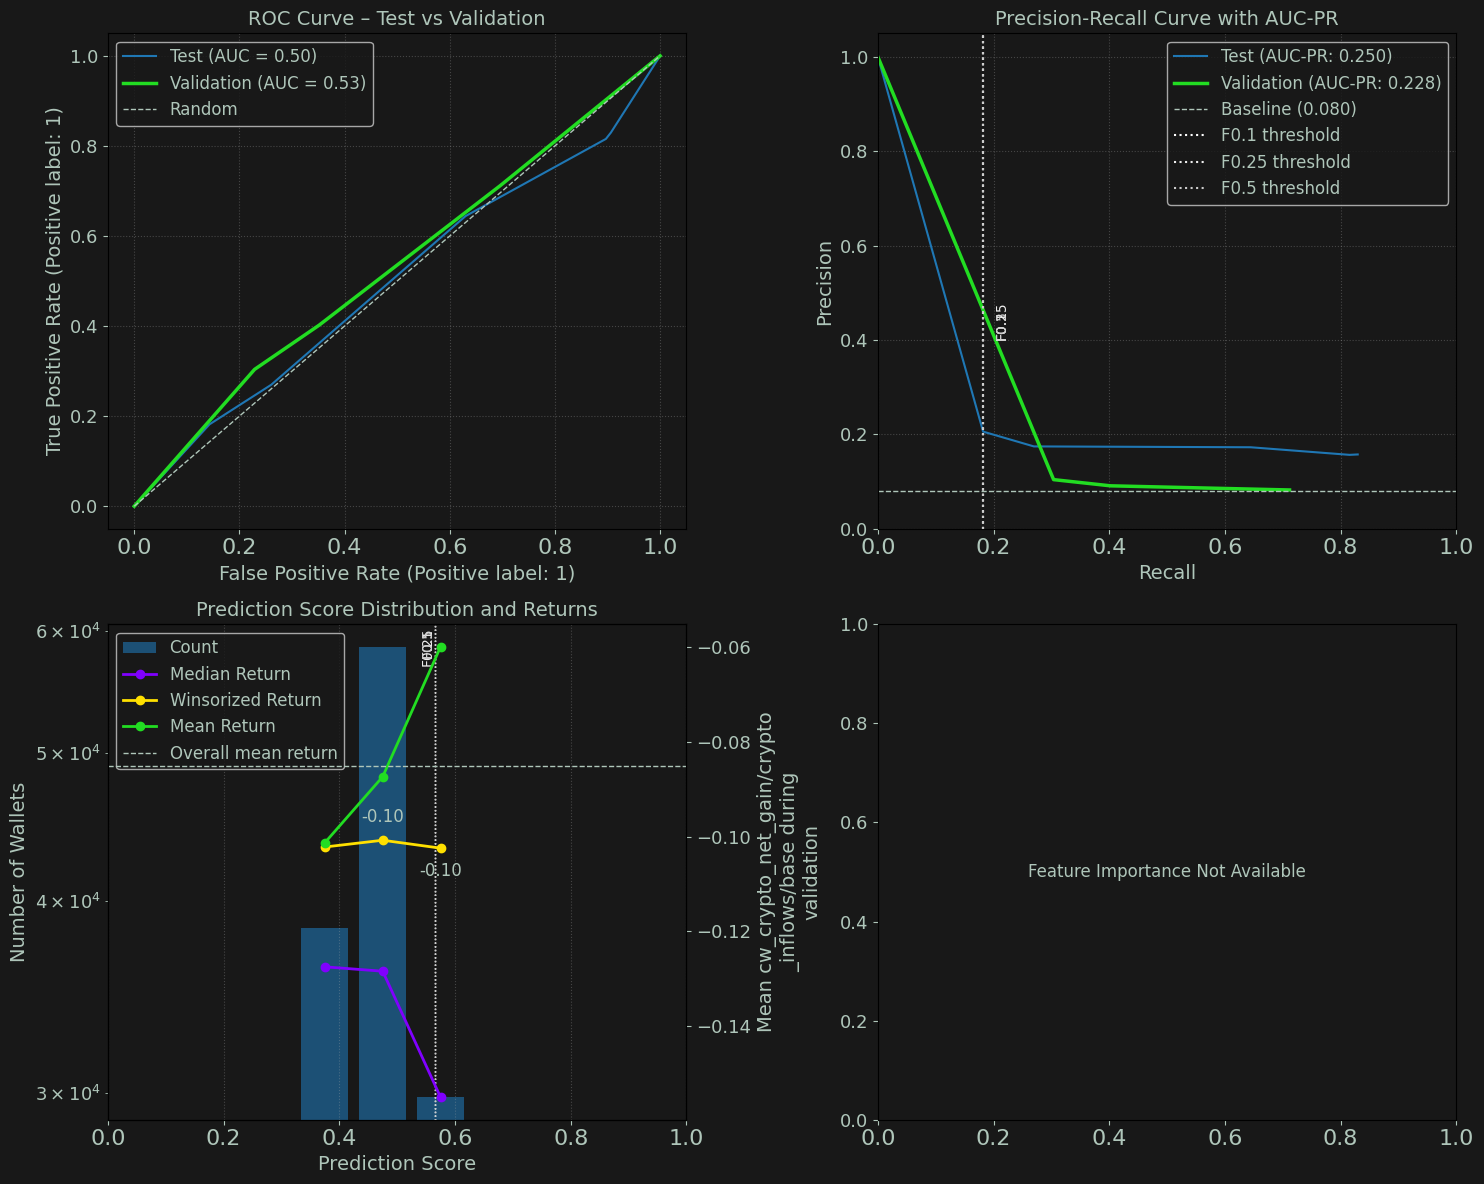

[13/Aug/25 17:44:18] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:18] WARNING [1138767417.<module>:5]                 240: 2025-01-30
[13/Aug/25 17:44:18] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:18] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh240/wscr-dda-956--sh240-0813-164642/output/model.tar.gz
Test Samples:             96,423
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.452  |  0.567
Val Accuracy:               0.297  |  0.550
Val Precision:              0.019  |  0.186
Val Recall:                 0.700  |  0.609
Val F1 Score:               0.036  |  0.285

Validation

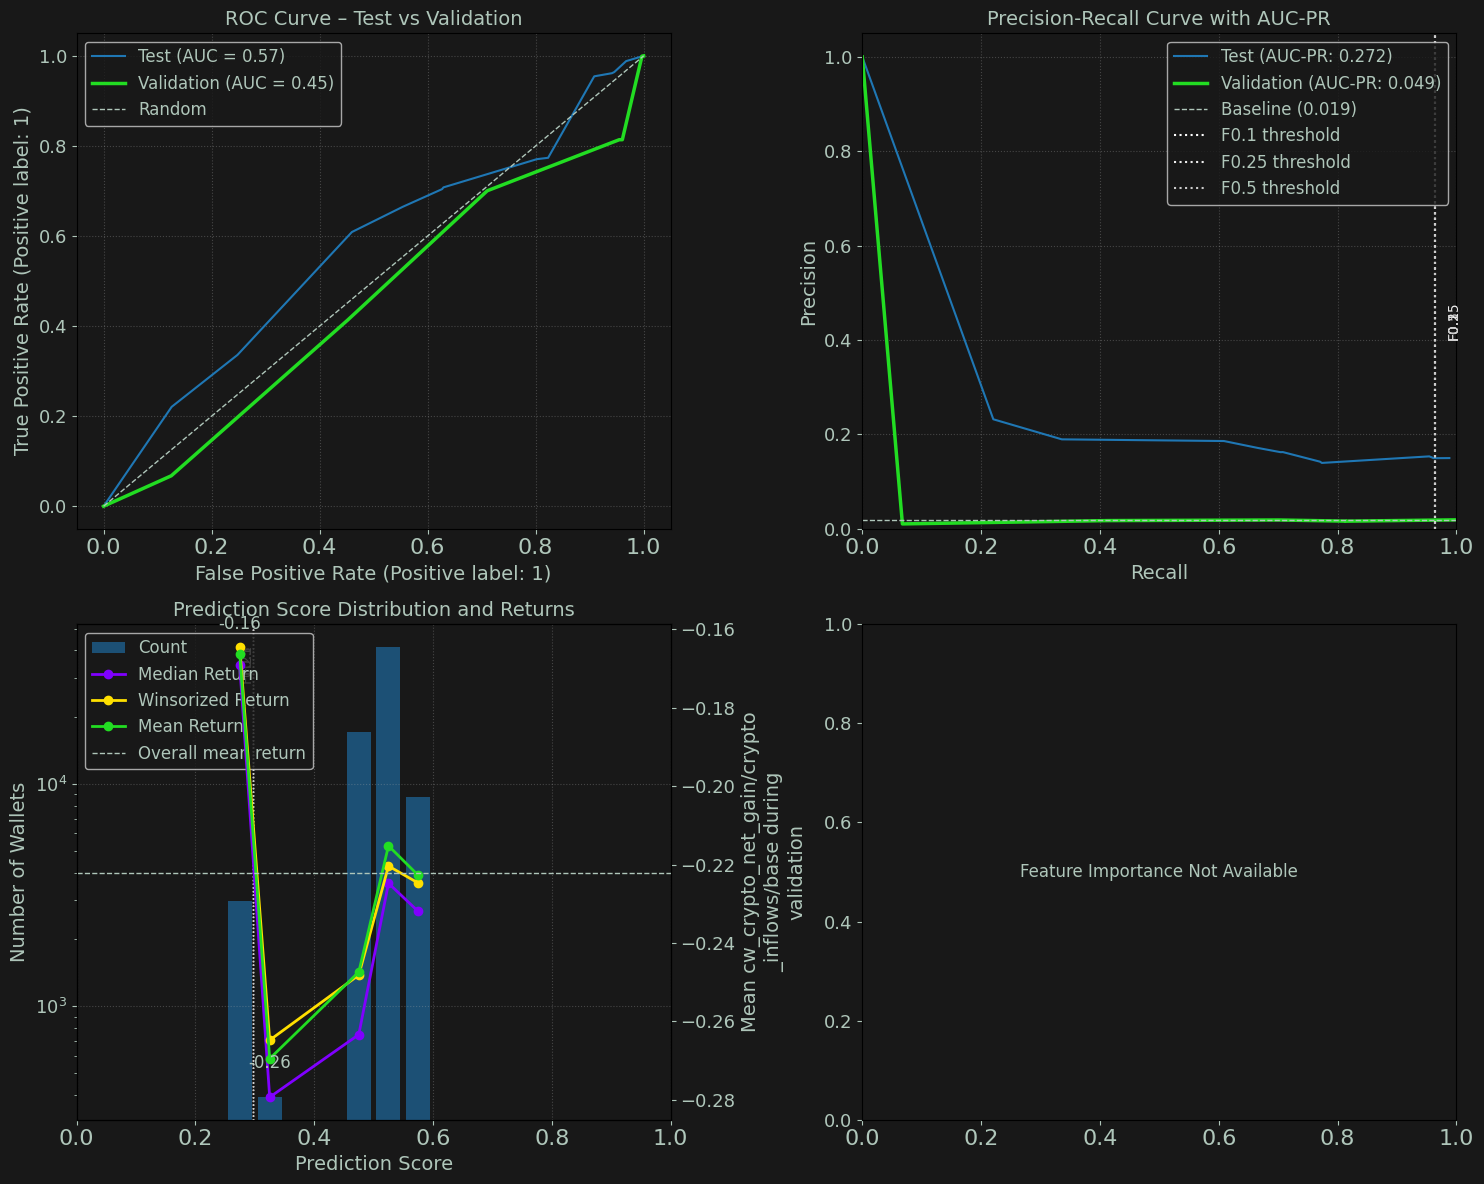

[13/Aug/25 17:44:19] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:19] WARNING [1138767417.<module>:5]                 300: 2025-03-31
[13/Aug/25 17:44:19] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:19] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh300/wscr-dda-956--sh300-0813-164642/output/model.tar.gz
Test Samples:             98,144
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.539  |  0.539
Val Accuracy:               0.548  |  0.645
Val Precision:              0.182  |  0.165
Val Recall:                 0.412  |  0.386
Val F1 Score:               0.252  |  0.231

Validatio

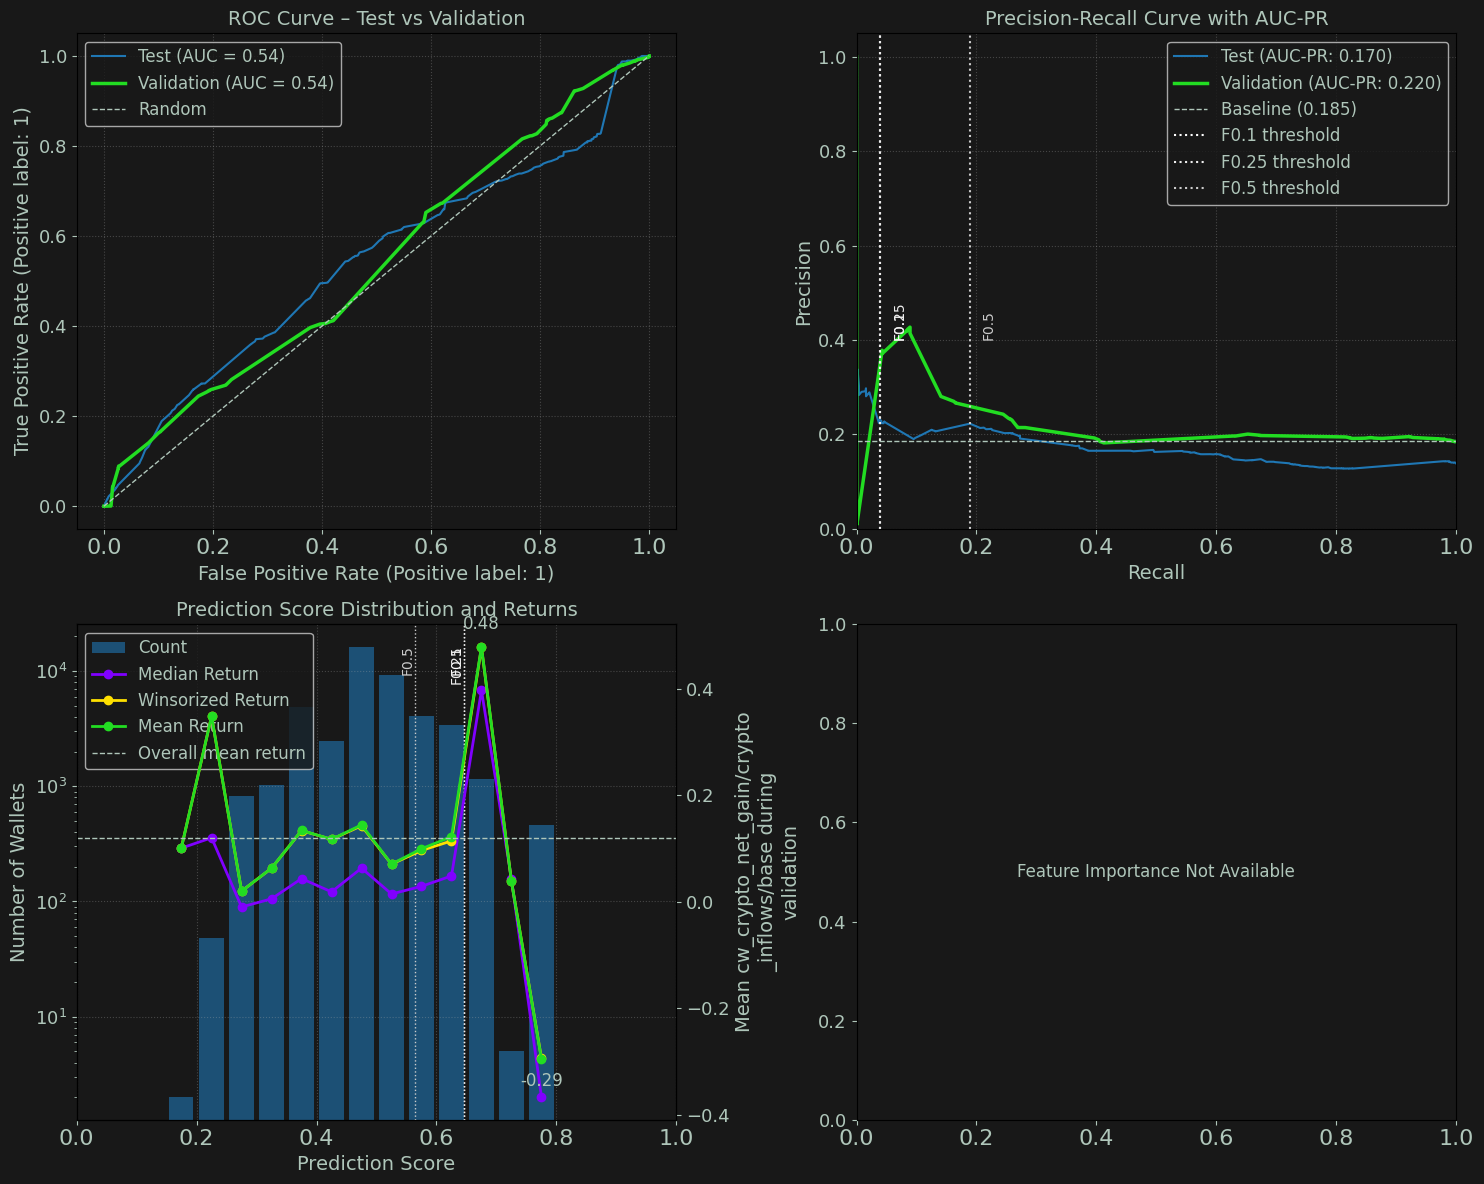

[13/Aug/25 17:44:19] INFO [1138767417.<module>:4] -------------------------------------------------
[13/Aug/25 17:44:19] WARNING [1138767417.<module>:5]                 360: 2025-05-30
[13/Aug/25 17:44:19] INFO [1138767417.<module>:6] -------------------------------------------------
[13/Aug/25 17:44:19] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importance/sh360/wscr-dda-956--sh360-0813-164642/output/model.tar.gz
Test Samples:             87,938
Val Positive Samples:     6,688 (15.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.610  |  0.587
Val Accuracy:               0.246  |  0.277
Val Precision:              0.167  |  0.121
Val Recall:                 0.974  |  0.860
Val F1 Score:               0.286  |  0.212

Validatio

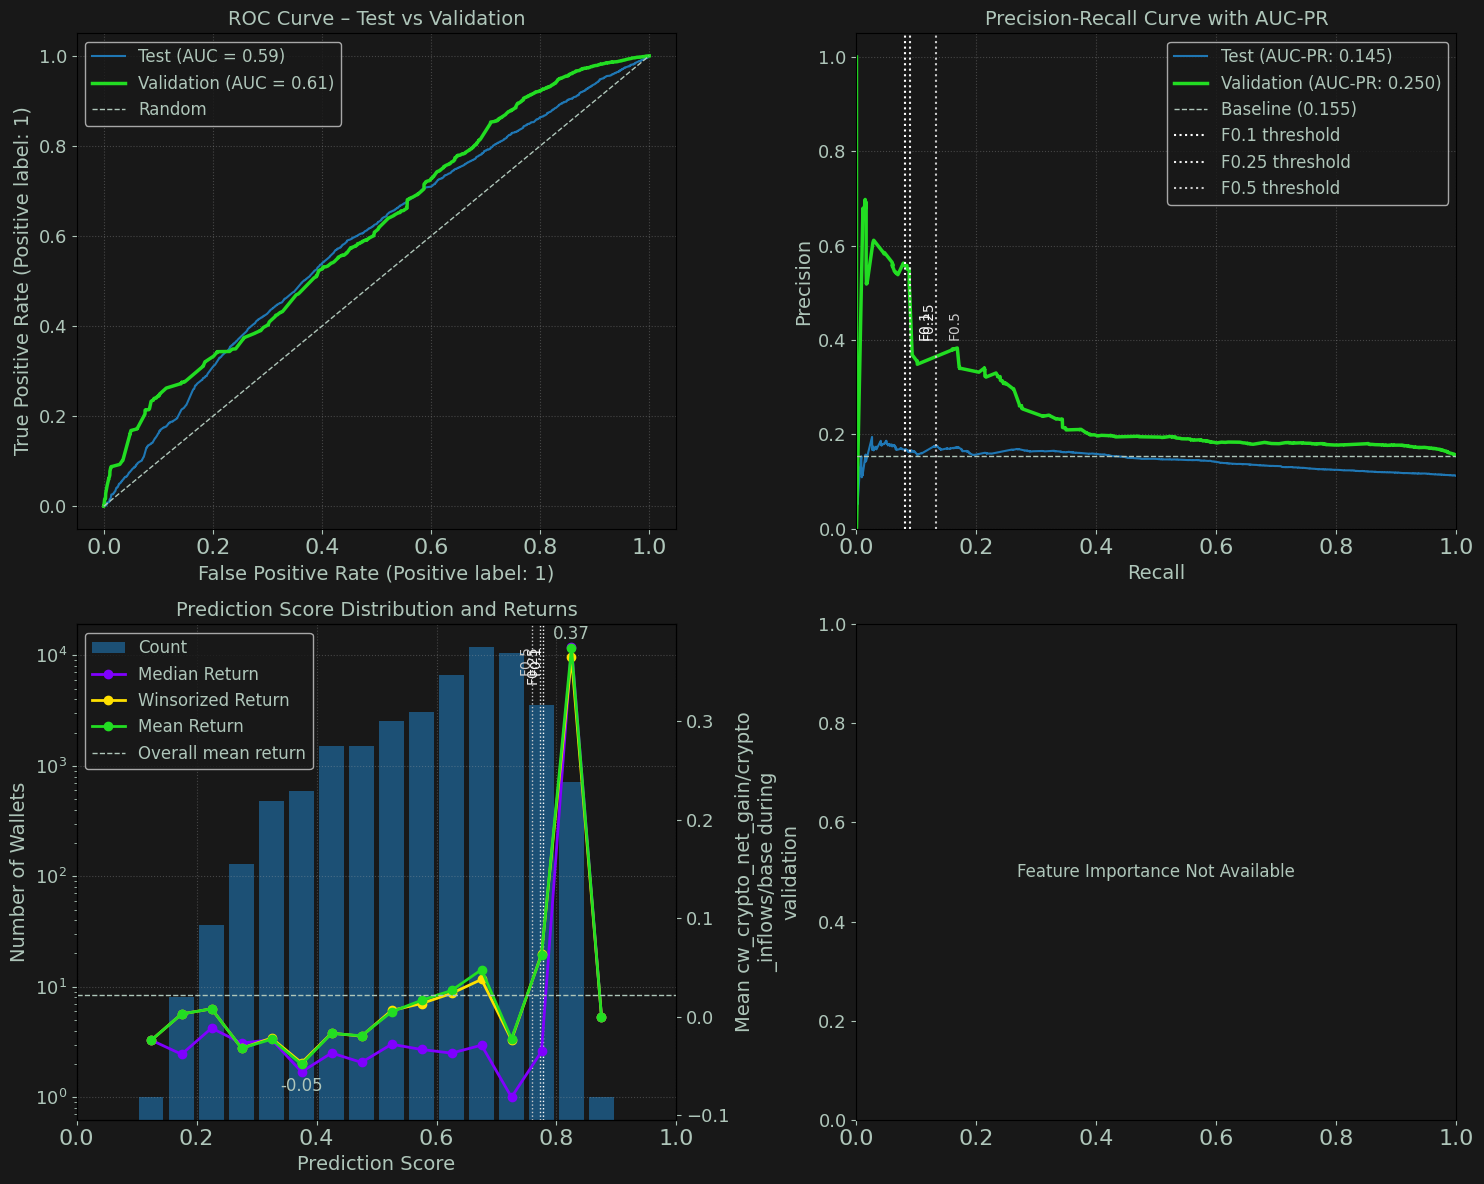

In [73]:
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable